In [1]:
%cd ..
%ls

/home/nas3_userJ/dmkim/OnlineTSAD
cfgs/         data/  Exp/   models/   plots/    test.py*   utils/  wandb/
checkpoints/  EDA/   logs/  outputs/  results/  train.py*  Vis/


In [2]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_anomaly

import warnings
from data.load_data import DataFactory
from Exp.ReconBaselines import *

from easydict import EasyDict as edict
import yaml
import re

warnings.filterwarnings("ignore")

In [3]:
# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})
cfg['dataset'] = 'SWaT'

In [4]:
args = prepare_arguments(cfg)
args.model.latent_dim = 128
args.window_size = 12
args.eval_batch_size = 1
args.dataset = "SWaT"
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-03-24 14:58:23,049] Configurations: {'exp_id': 'MLP_SWaT', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT', 'log_path': './logs/MLP_SWaT', 'output_path': './outputs/MLP_SWaT', 'plot_path': './plots/MLP_SWaT', 'result_path': './results/MLP_SWaT', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}
[2023-03-24 14:58:23,051] Preparing SWaT dataset...
[2023-03-24 14:58:23,052] current location: /home/nas3_userJ/dmkim/OnlineTSAD
[2023-03-24 14:58:23,052] home dir: .
[2023-03-24 14:58:23,054] Preparing SWaT ...


{'exp_id': 'MLP_SWaT', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT', 'log_path': './logs/MLP_SWaT', 'output_path': './outputs/MLP_SWaT', 'plot_path': './plots/MLP_SWaT', 'result_path': './results/MLP_SWaT', 'thresholding': 'oracle', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}


[2023-03-24 14:58:32,813] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-03-24 14:58:32,892] Complete.
[2023-03-24 14:58:32,897] Preparing dataloader...
[2023-03-24 14:58:33,532] total train dataset- 7763, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-03-24 14:58:33,534] total test dataset- 37493, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-03-24 14:58:33,535] Complete.


(496800, 51) (496800,) (449916, 51) (449916,)


## Visualize

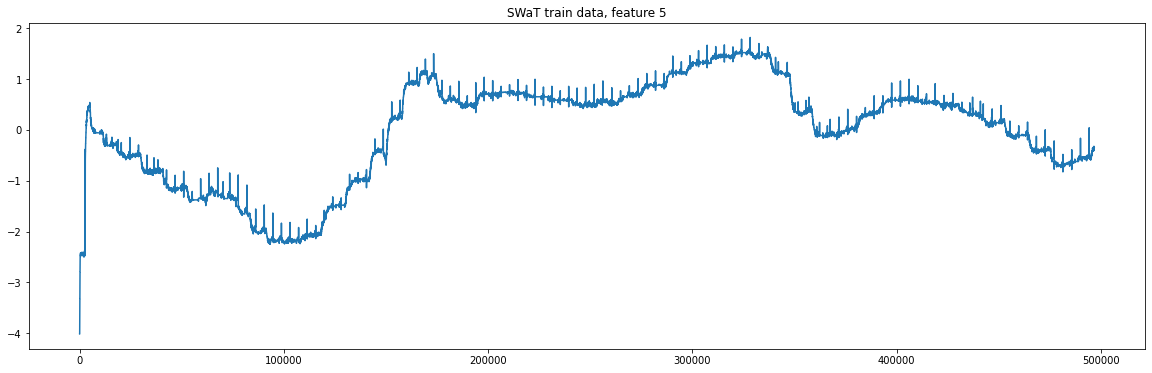

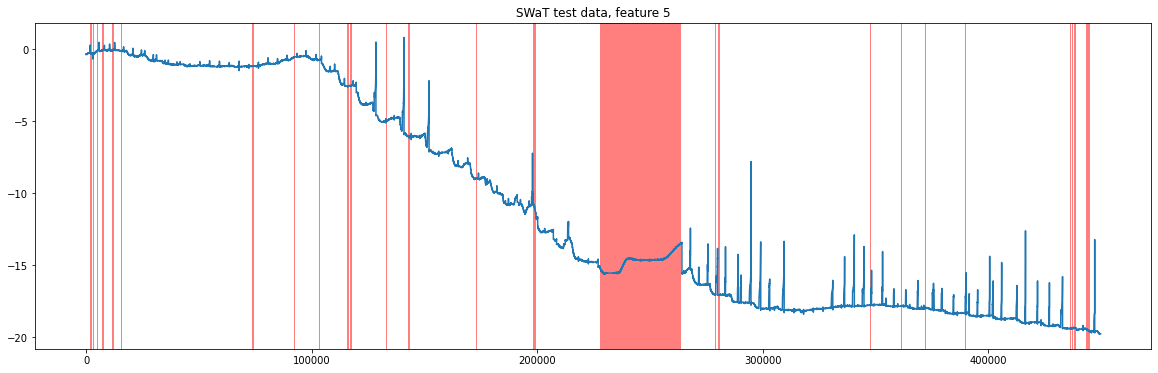

In [5]:
C = 5
dataset = "SWaT"
datafactory.visualize_dataset(train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y, dataset_name=dataset, feature_idx=C)

## Load Model

In [23]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

[2023-03-24 15:05:54,096] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict
[2023-03-24 15:05:54,106] train_errors.pt file exists, loading...
[2023-03-24 15:05:54,122] torch.Size([496789, 12])
[2023-03-24 15:05:54,315] loading: ./checkpoints/MLP_SWaT/best.pth @Trainer - torch.load_state_dict


In [7]:
next(iter(tester.model.parameters())).device, next(iter(tester.model.parameters())).requires_grad

(device(type='cuda', index=0), True)

## Training statistics

In [8]:
train_iterator = tqdm(
    tester.train_loader,
    total=len(tester.train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

recon_errors = []
with torch.no_grad():
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
        recon_error = torch.nn.functional.mse_loss(Xhat, X, reduction='none')
        recon_errors.append(recon_error)

recon_errors = torch.cat(recon_errors, axis=0)

train_error_dist = recon_errors.mean(dim=(1, 2))

print(f"{recon_errors.shape}, {train_error_dist.shape}")

calculating reconstruction errors: 100%|██████████| 7763/7763 [00:13<00:00, 581.77it/s]

torch.Size([496789, 12, 51]), torch.Size([496789])


## Test: static threshold inference

In [9]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

anoscs_prev = []
Xhats_prev = []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
        Xhats_prev.append(Xhat)        
        e = F.mse_loss(Xhat, X, reduction='none')
        anosc = e.mean(dim=2)
        anoscs_prev.append(anosc)

Xhats_prev = torch.cat(Xhats_prev, axis=0).detach().cpu().numpy()
anoscs_prev = torch.cat(anoscs_prev, axis=0).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [00:34<00:00, 1075.53it/s]


In [10]:
th_q95 = torch.quantile(train_error_dist, 0.95).item()
th_q99 = torch.quantile(train_error_dist, 0.99).item()
th_q100 = torch.max(train_error_dist).item()
th_best_static = tester.get_best_static_threshold(gt=test_y, anomaly_scores=anoscs_prev)
th_q95, th_q99, th_q100, th_best_static

[2023-03-24 14:59:26,099] Best threshold found at: 7.9125590324401855, with fpr: 0.007262250462902067, tpr: 0.6276198153304998
tn: 392461 fn: 20326
fp: 2871 tp: 34258


(0.009716848842799664, 0.04816127195954323, 6.910831451416016, 7.912559)

In [11]:
# 95
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q95))
# 99
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q99))
# 100
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q100))
# oracle
print(get_summary_stats(test_dataset.y, anoscs_prev > th_best_static))

{'Accuracy': 0.2798144542536829, 'Precision': 0.14097681744168383, 'Recall': 0.9691484684156529, 'F1': 0.24614783294518905, 'tn': 72993, 'fp': 322339, 'fn': 1684, 'tp': 52900}
{'Accuracy': 0.3467002729398377, 'Precision': 0.149155672823219, 'Recall': 0.932086325663198, 'F1': 0.2571597537428858, 'tn': 105109, 'fp': 290223, 'fn': 3707, 'tp': 50877}
{'Accuracy': 0.9476768996879418, 'Precision': 0.9136750086618161, 'Recall': 0.6280595046167375, 'F1': 0.7444112697464851, 'tn': 392093, 'fp': 3239, 'fn': 20302, 'tp': 34282}
{'Accuracy': 0.9484392642182097, 'Precision': 0.9226729153199742, 'Recall': 0.6276014949435732, 'F1': 0.7470560013956733, 'tn': 392461, 'fp': 2871, 'fn': 20327, 'tp': 34257}


### Label-guided Online learning

In [22]:
init_thr = torch.quantile(train_error_dist, 0.95).item()
thr = torch.tensor(init_thr, requires_grad=True)
#thr = init_thr
thr

tensor(0.0097, requires_grad=True)

In [24]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
# TH_optimizer = torch.optim.SGD([p for p in tester.model.parameters()], lr=lr)

TH_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = tester.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    pred = (anosc > thr)
    preds.append(pred)
    
    # update
    TH_optimizer.zero_grad()
    yhat = torch.sigmoid(anosc-thr)
    yhats.append(yhat)
    cls_loss = bce(yhat, y.float())
    mask = ((y == 0).unsqueeze(2))
    recon_loss = (e*mask).mean()
    loss = cls_loss + recon_loss
    loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
#thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [02:44<00:00, 227.93it/s]


In [25]:
print(test_y.shape, preds.shape)
get_summary_stats(test_y, preds)

(449916,) (449916,)


{'Accuracy': 0.9791961166084335,
 'Precision': 0.9686230622564868,
 'Recall': 0.856258244174117,
 'F1': 0.908981290598623,
 'tn': 393818,
 'fp': 1514,
 'fn': 7846,
 'tp': 46738}

In [26]:
s, e = None, None
for i in range(len(test_y)):
    if test_y[i] == 1 and s is None:
        s = i
    elif test_y[i] == 0 and s is not None:
        e = i - 1
        print(f"[{s}, {e}], {preds[s:e].sum()} / {e-s+1}")
        s, e = None, None

[1754, 2693], 226 / 940
[3068, 3510], 214 / 443
[4920, 5302], 100 / 383
[6459, 6848], 0 / 390
[7255, 7450], 185 / 196
[7705, 8133], 410 / 429
[11410, 12373], 950 / 964
[15380, 16100], 720 / 721
[73800, 74520], 0 / 721
[90685, 90917], 0 / 233
[92140, 92570], 0 / 431
[93445, 93720], 0 / 276
[103092, 103808], 315 / 717
[115843, 116101], 0 / 259
[116143, 116537], 372 / 395
[117000, 117720], 0 / 721
[132918, 133380], 462 / 463
[142954, 143650], 254 / 697
[172305, 172588], 0 / 284
[172910, 173521], 133 / 612
[198296, 199740], 1210 / 1445
[227828, 263727], 35729 / 35900
[279120, 279240], 0 / 121
[280060, 281230], 1023 / 1171
[302653, 303019], 247 / 367
[347679, 348279], 447 / 601
[361191, 361634], 244 / 444
[371479, 371579], 0 / 101
[371855, 372335], 336 / 481
[389680, 390219], 399 / 540
[436541, 437009], 424 / 469
[437417, 437697], 237 / 281
[438147, 438547], 326 / 401
[438621, 438917], 257 / 297
[443501, 445190], 1502 / 1690


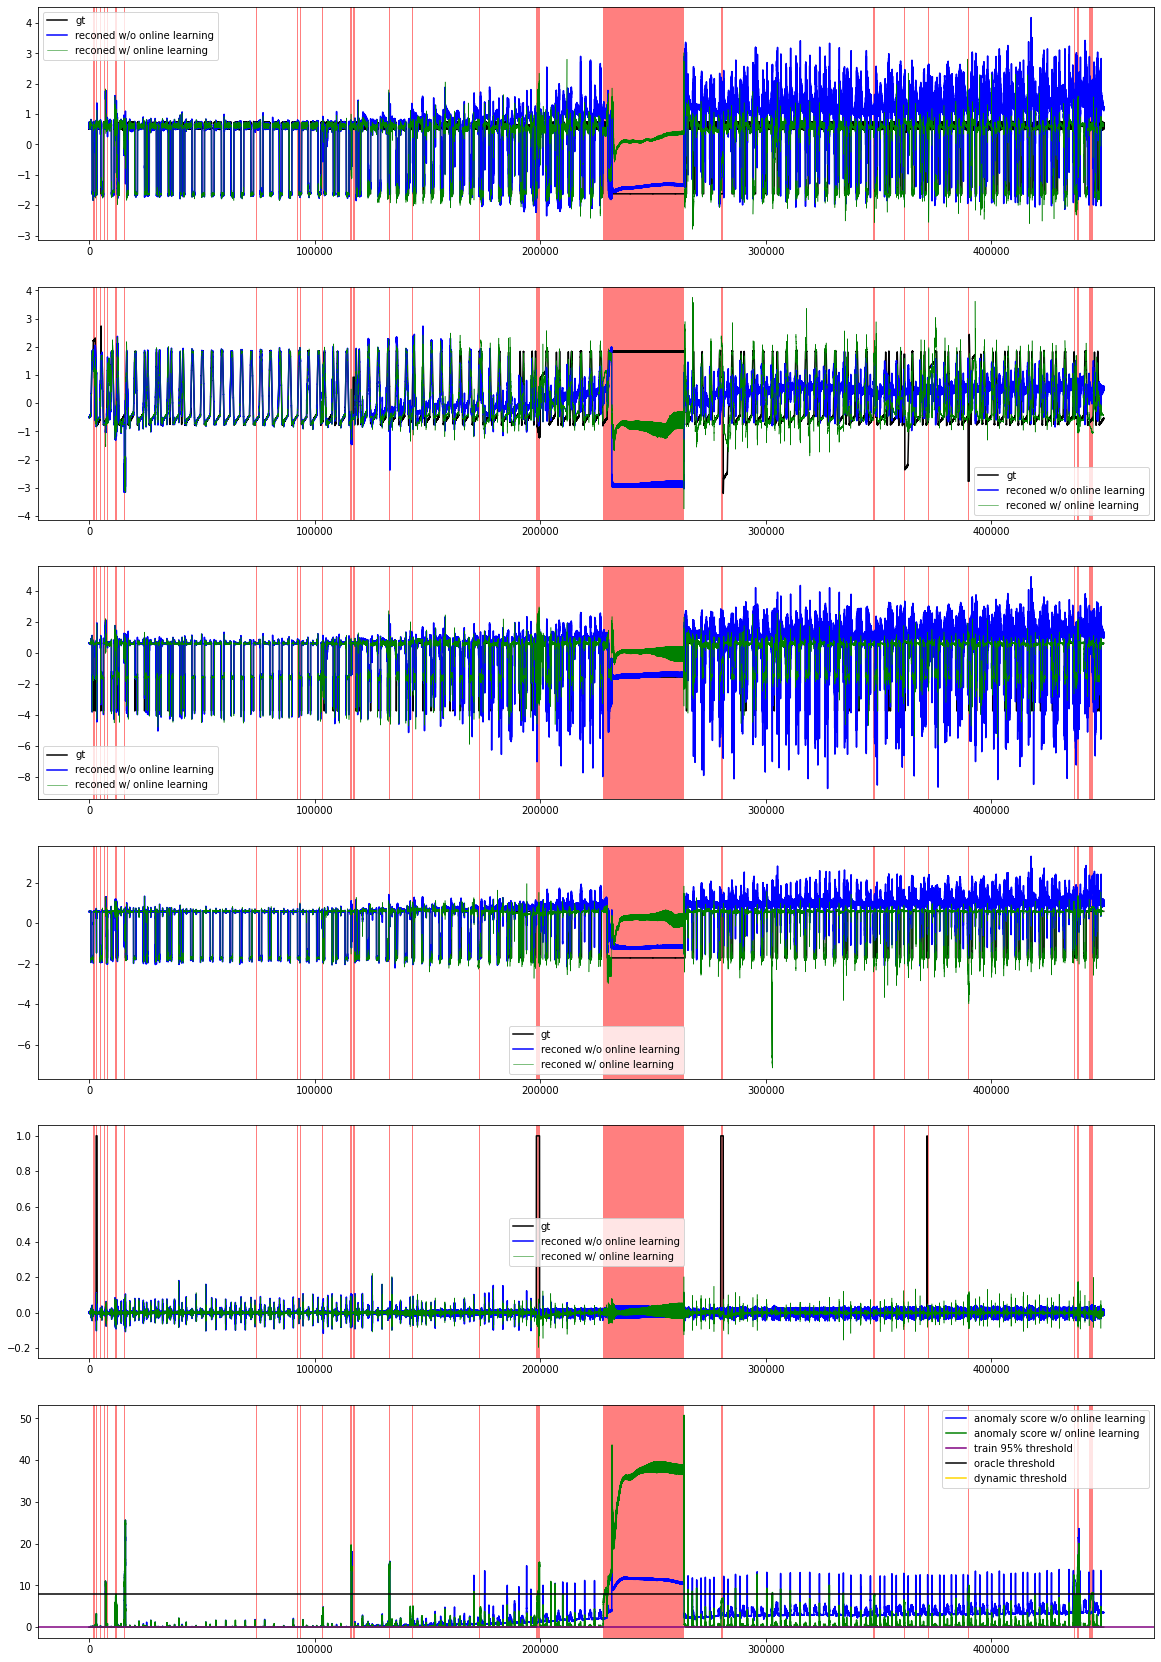

In [27]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(min(args.num_channels, 5)):
    # gt
    ax[c].plot(test_X[:, c], color="black", label="gt")
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    ax[c].legend()

#ax[5].set_ylim([-1, 20])
ax[5].plot(anoscs_prev.reshape(-1), color="blue", label="anomaly score w/o online learning")
ax[5].plot(anoscs.reshape(-1), color="green", label="anomaly score w/ online learning")
ax[5].axhline(th_q95, color="purple", label="train 95% threshold")
ax[5].axhline(th_best_static, color="black", label="oracle threshold")
ax[5].plot(thrs, color="gold",label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

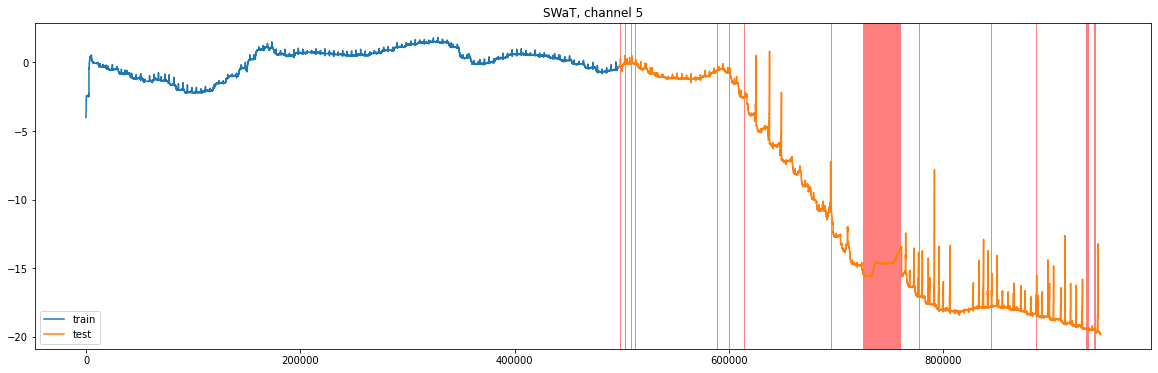

In [16]:
c=5
plt.figure(figsize=(20, 6))
plt.title(f"{args.dataset}, channel {c}")
plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")
lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

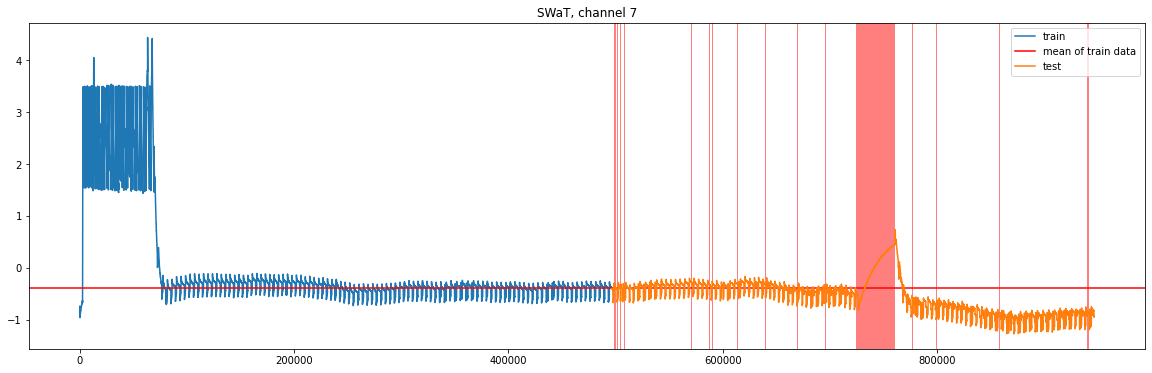

In [17]:
c=7
plt.figure(figsize=(20, 6))
#plt.ylim(-6, 6)
plt.title(f"{args.dataset}, channel {c}")

plt.plot(train_X[:, c], label="train", color="#1f77b4")
plt.axhline(train_X[100000:, c].mean(), color = 'r', label="mean of train data")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], label="test", color="#ff7f0e")

lb = np.concatenate([np.zeros(len(train_X)), test_y])
plot_anomaly(plt, lb)
plt.legend()
plt.show()

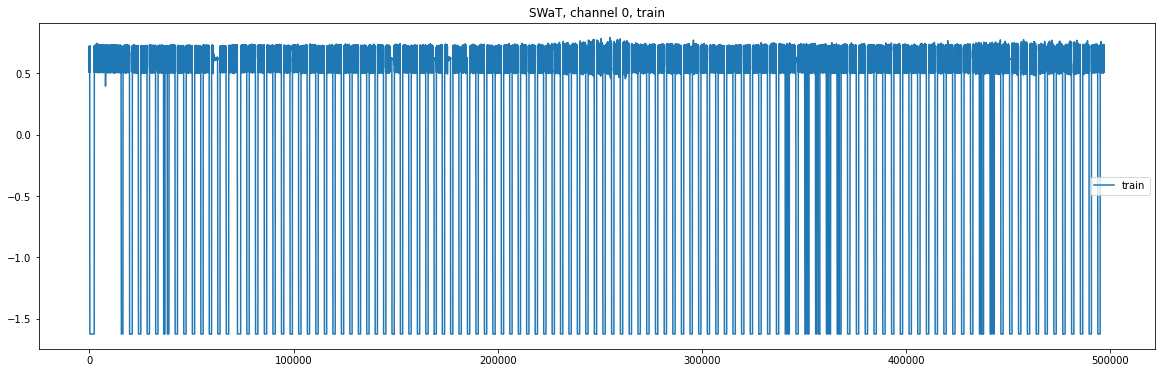

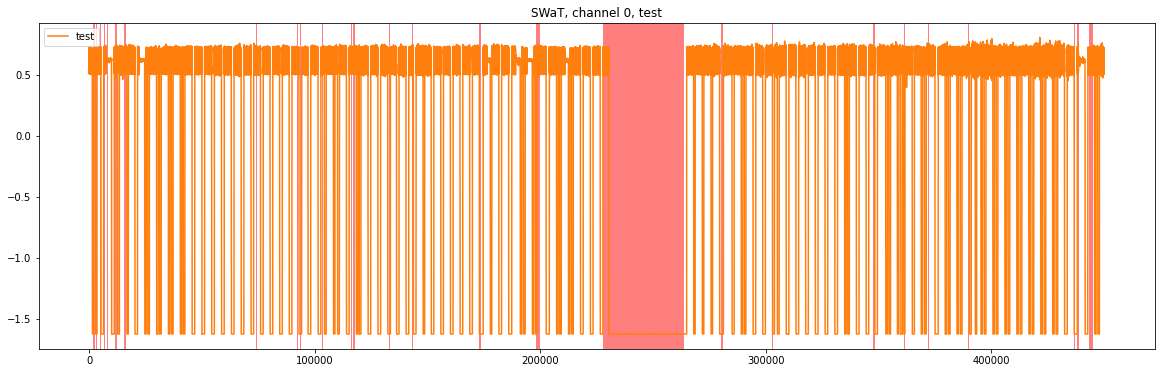

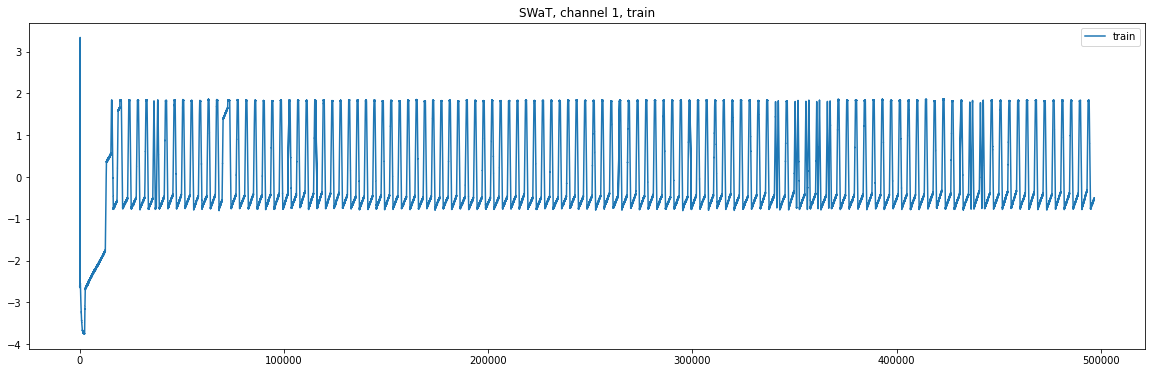

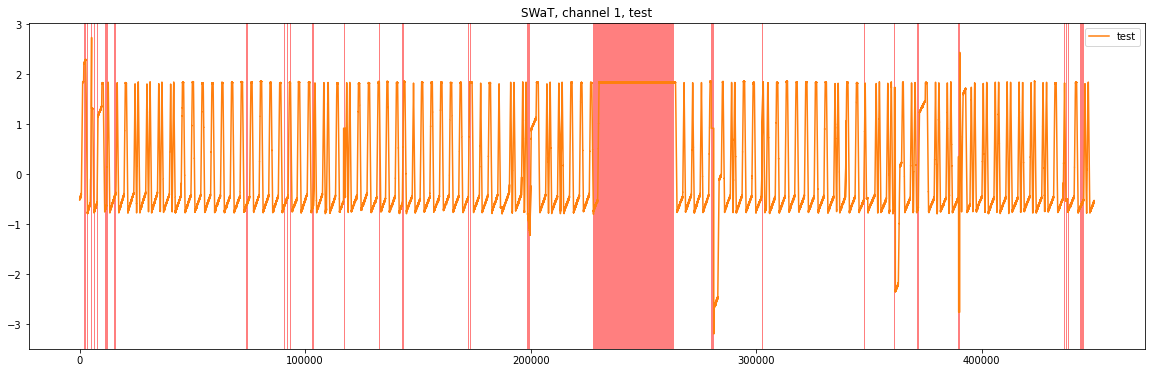

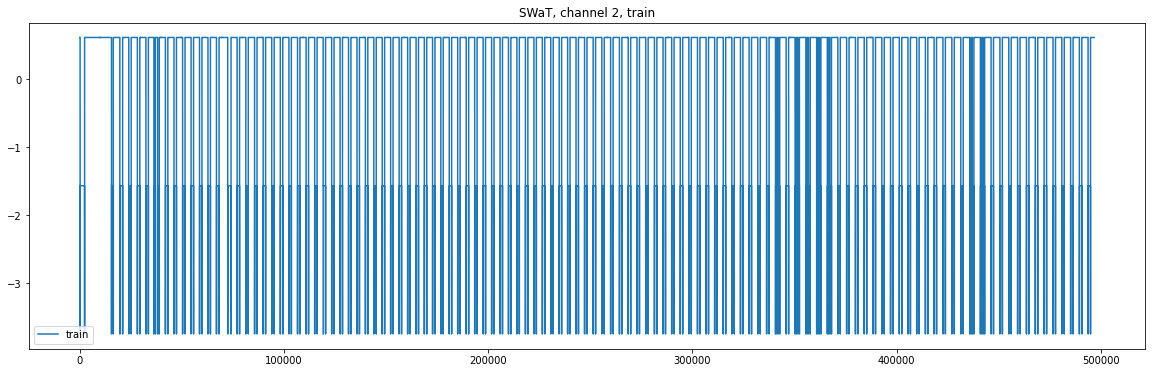

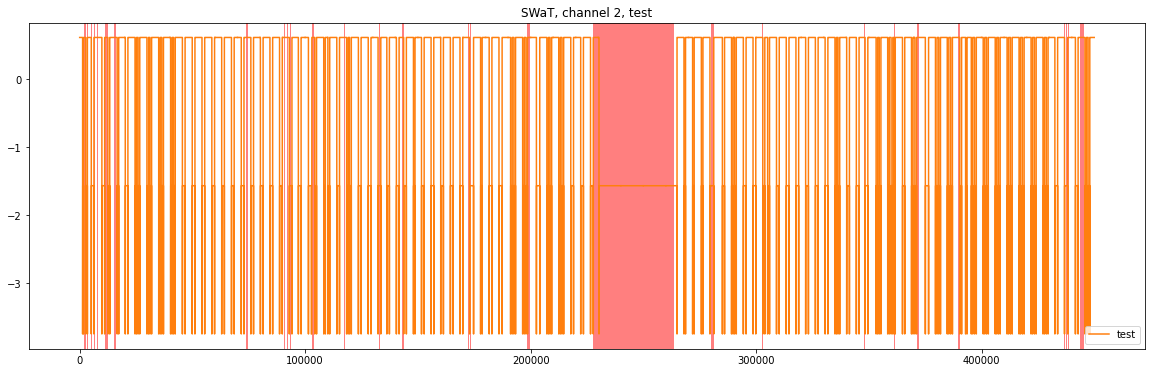

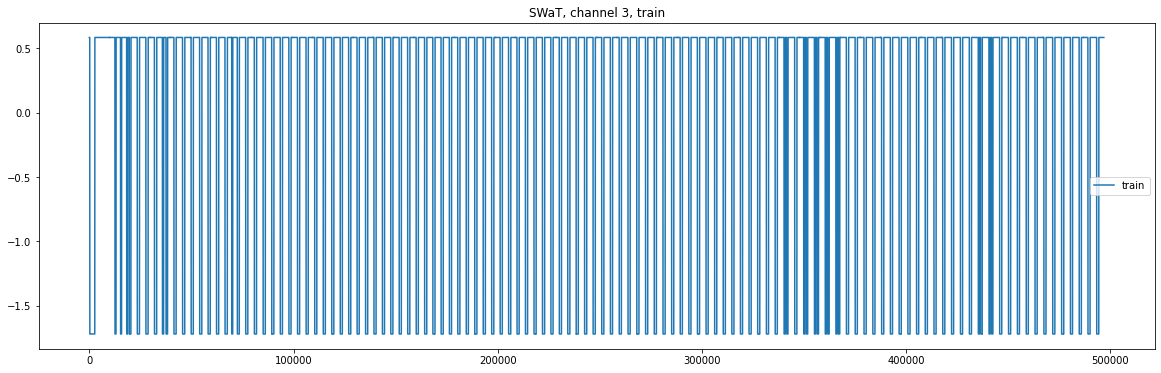

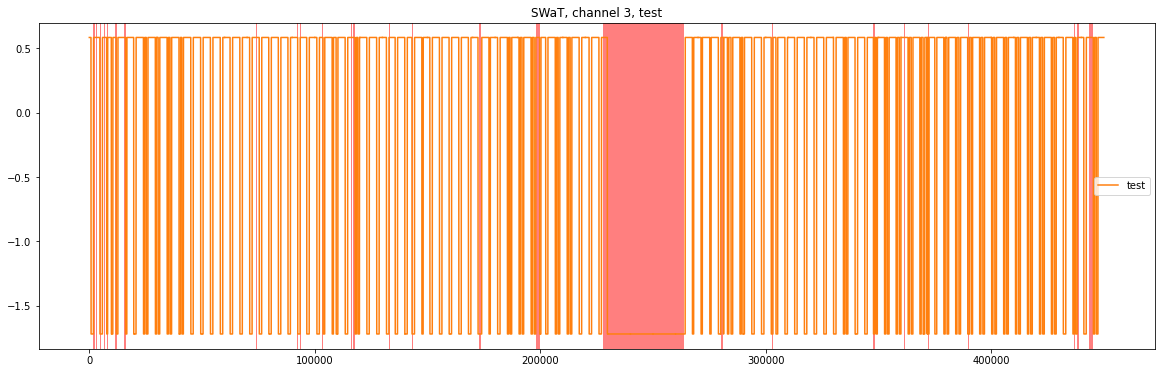

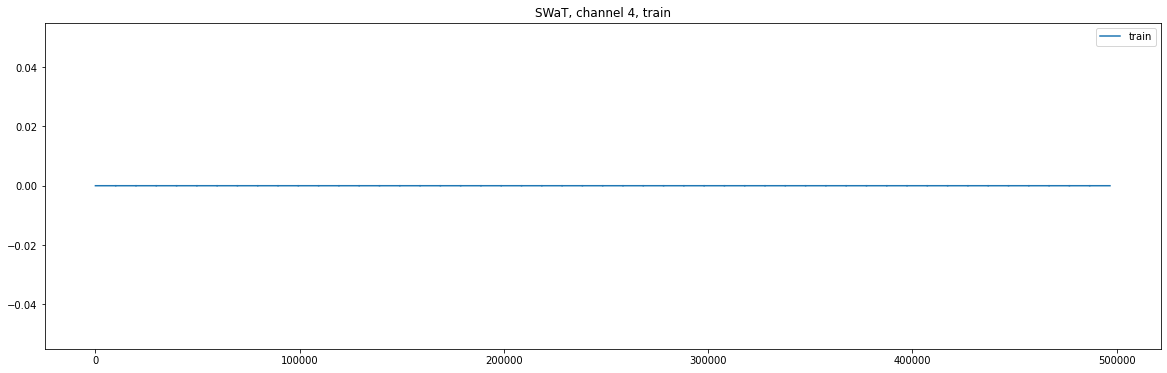

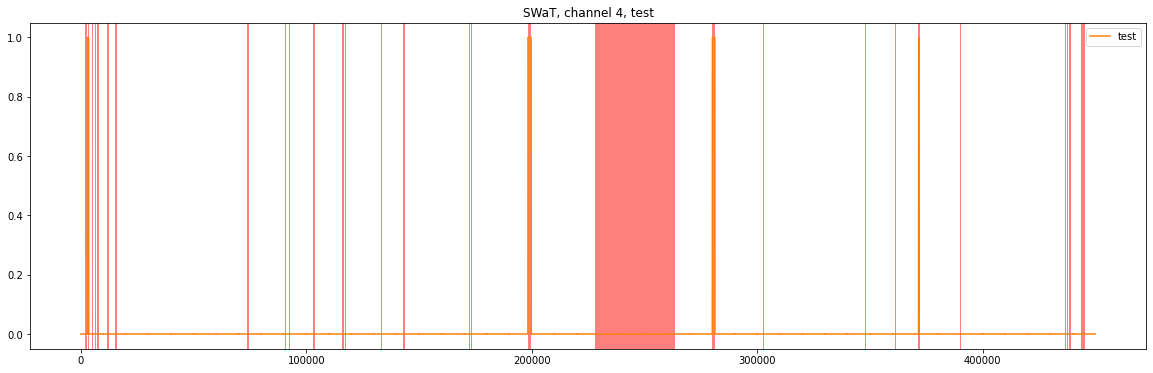

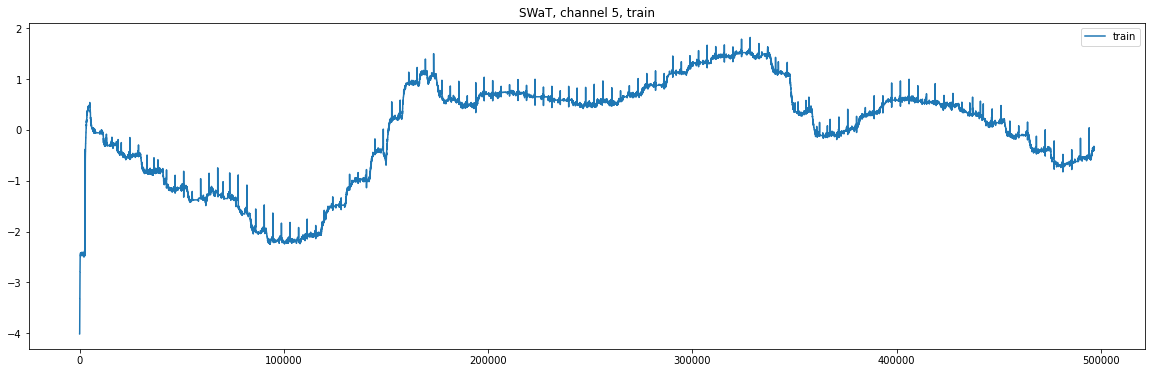

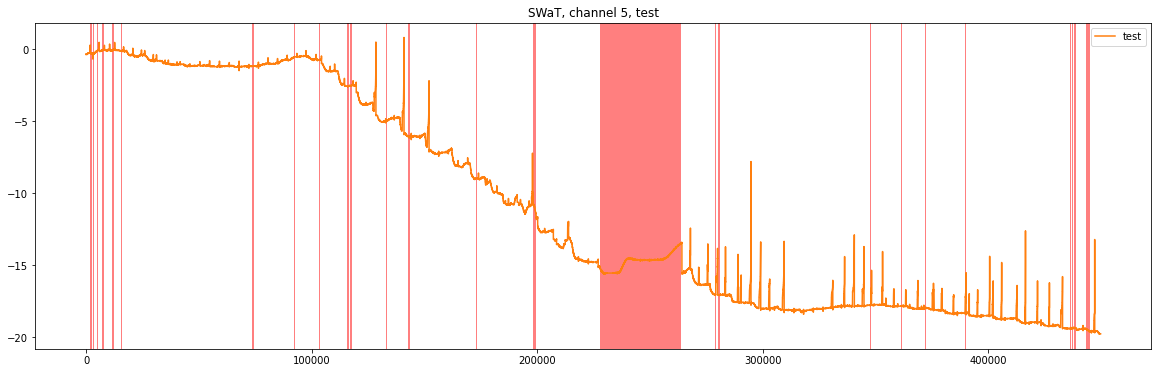

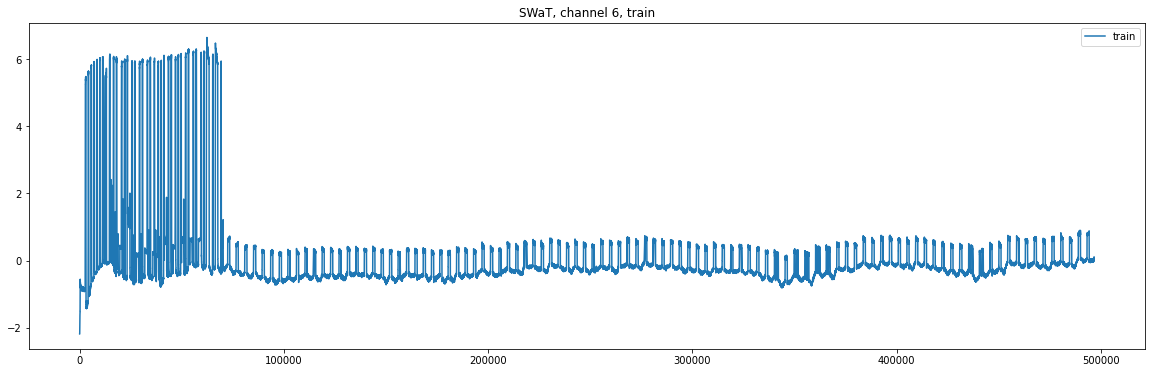

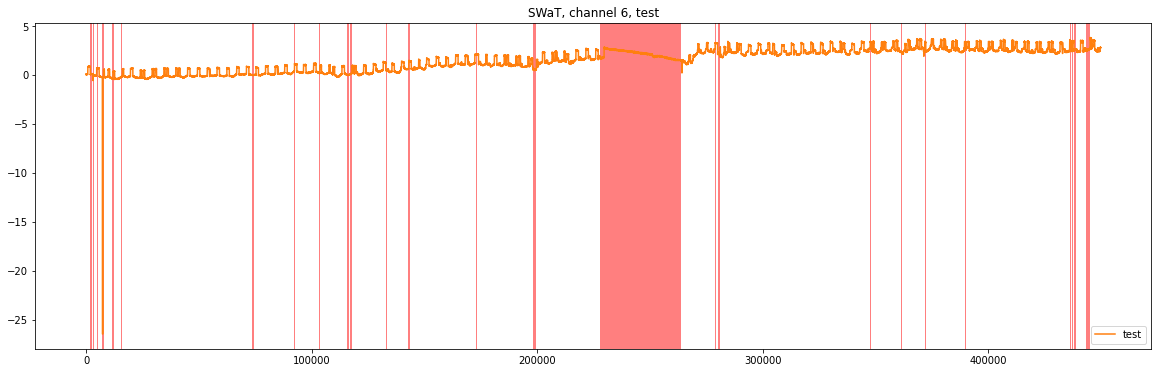

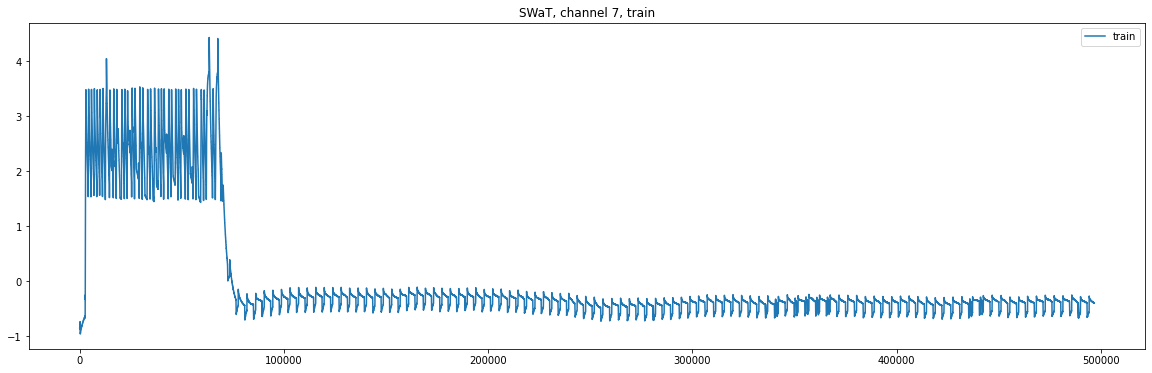

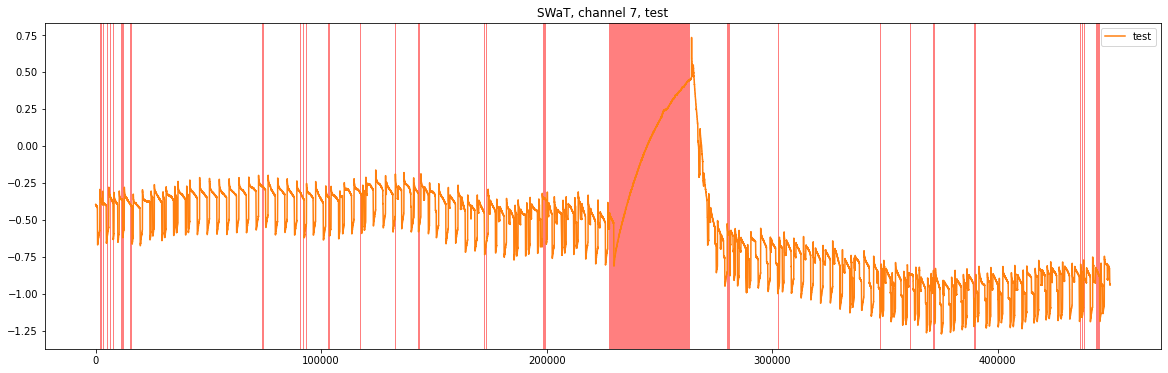

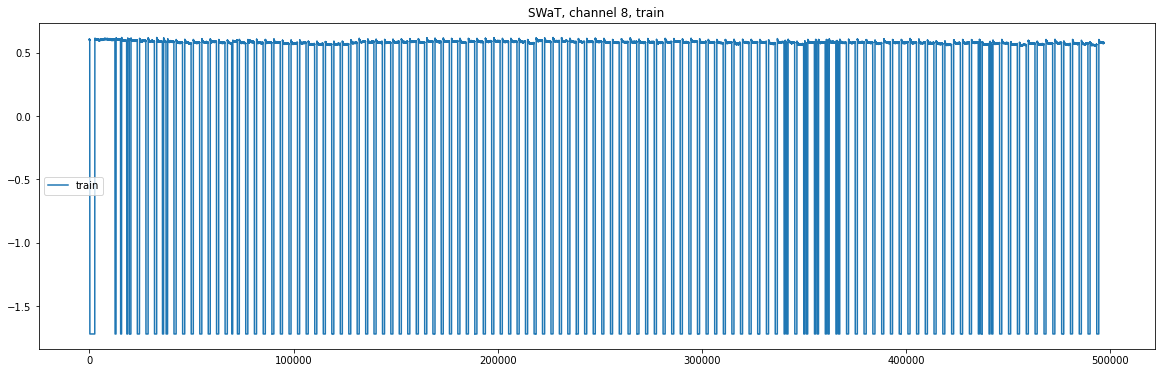

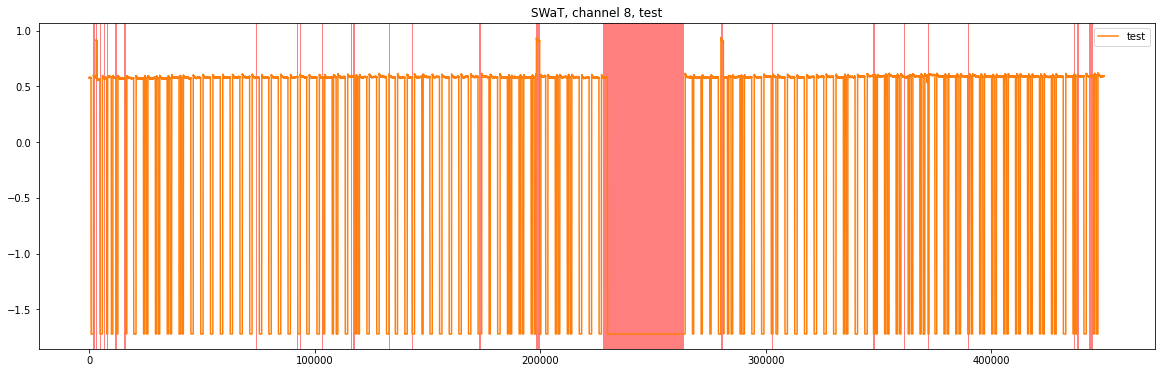

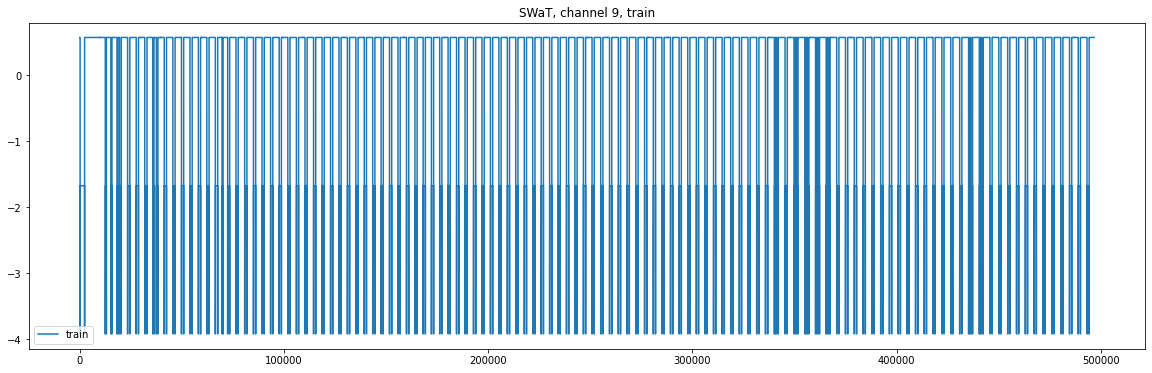

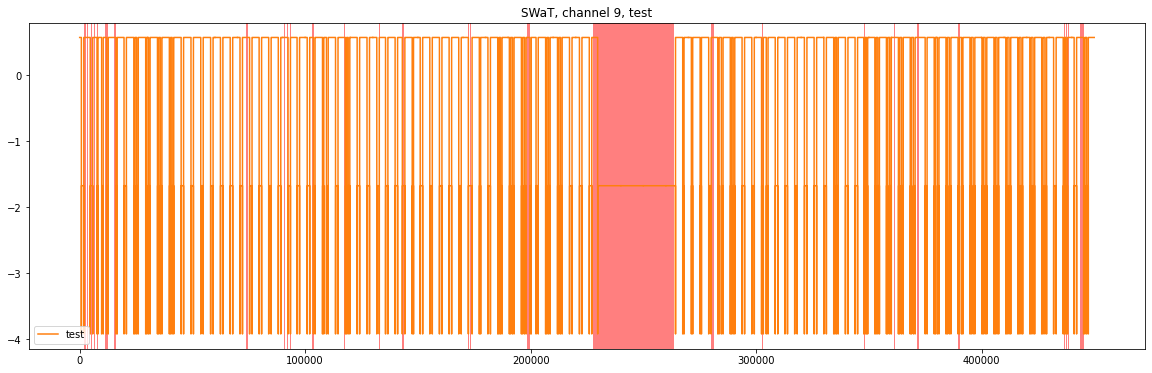

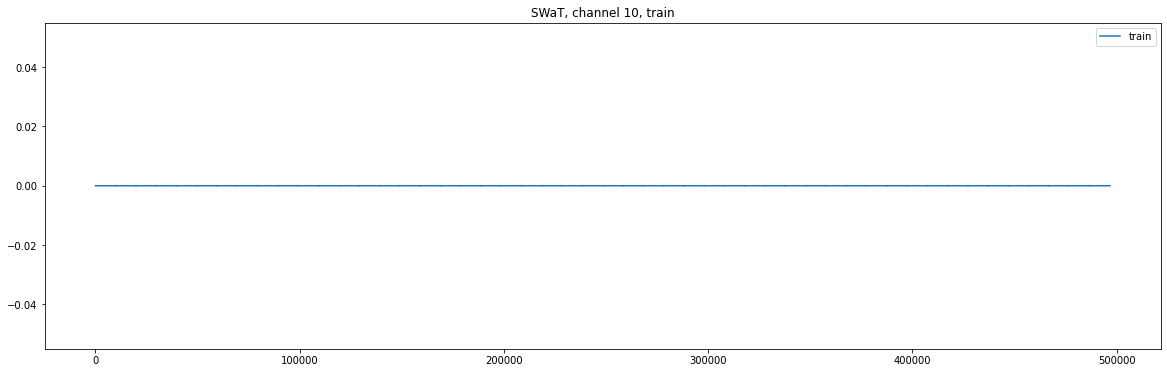

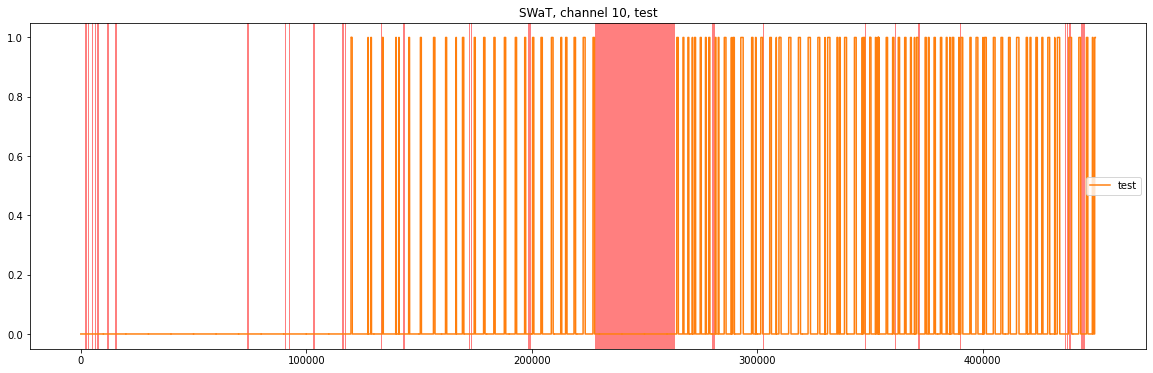

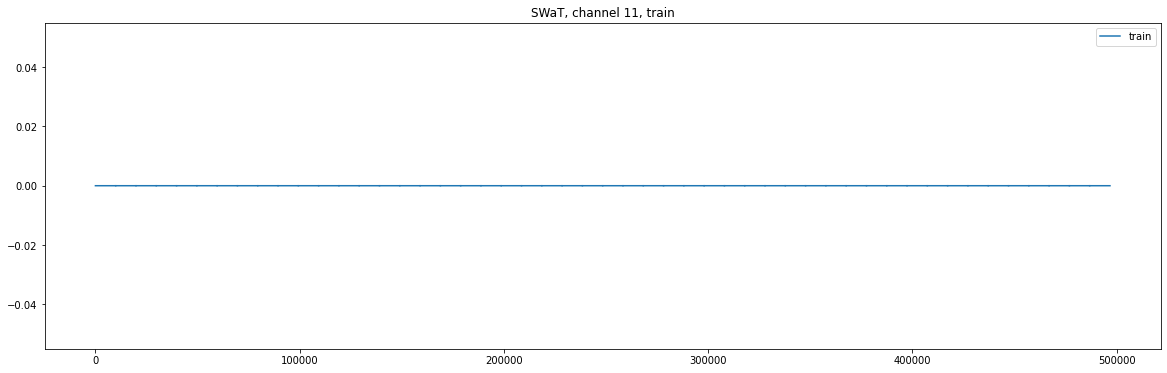

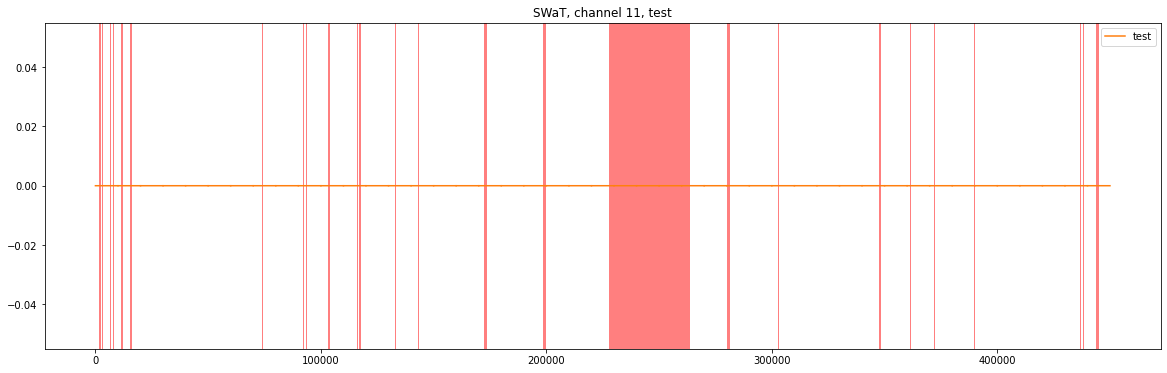

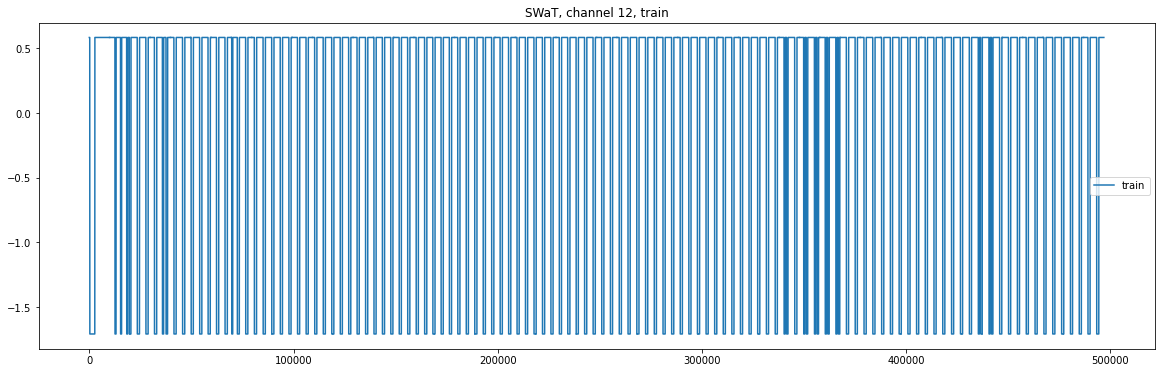

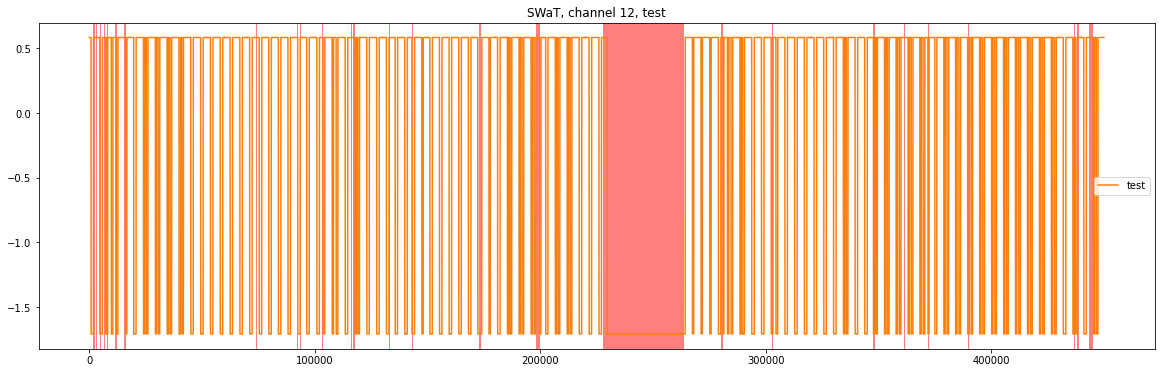

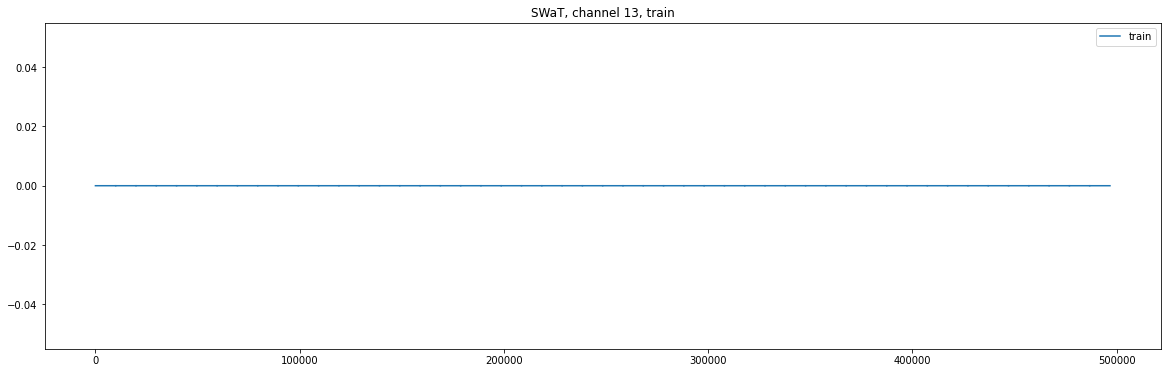

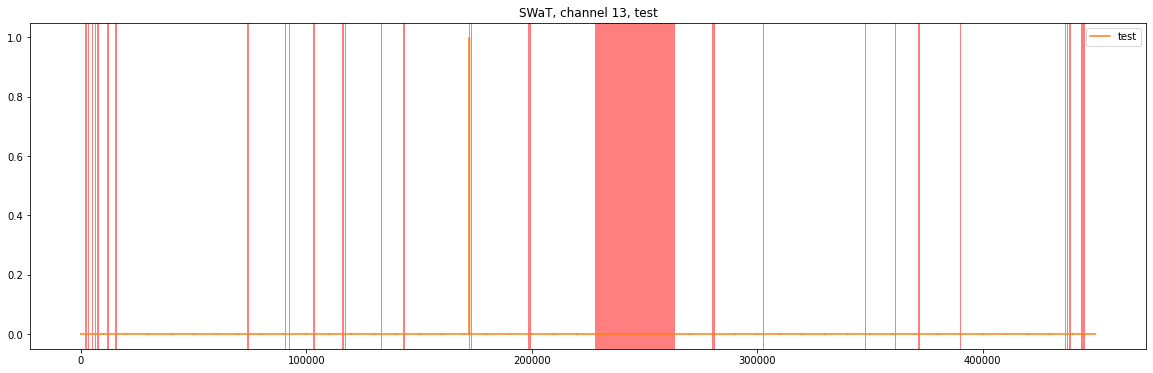

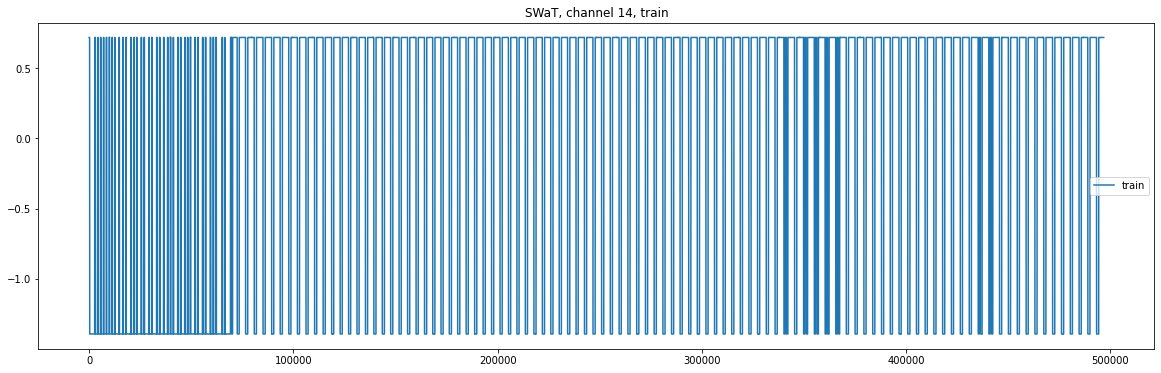

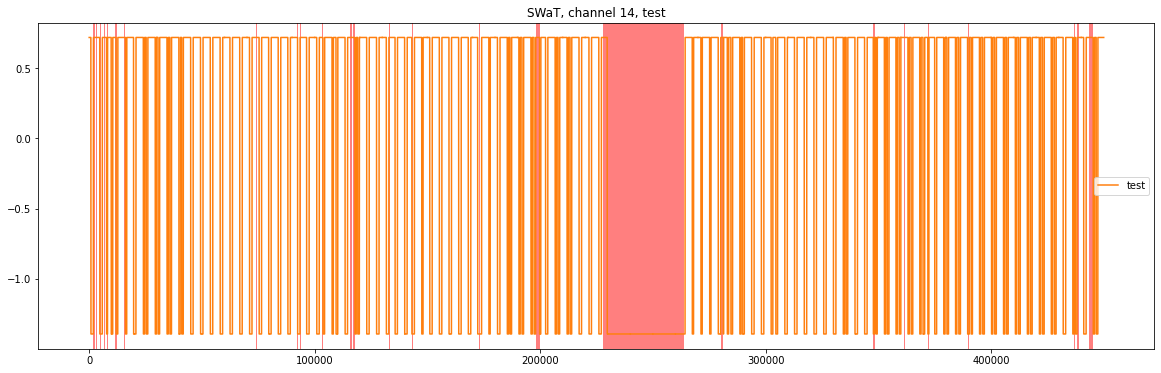

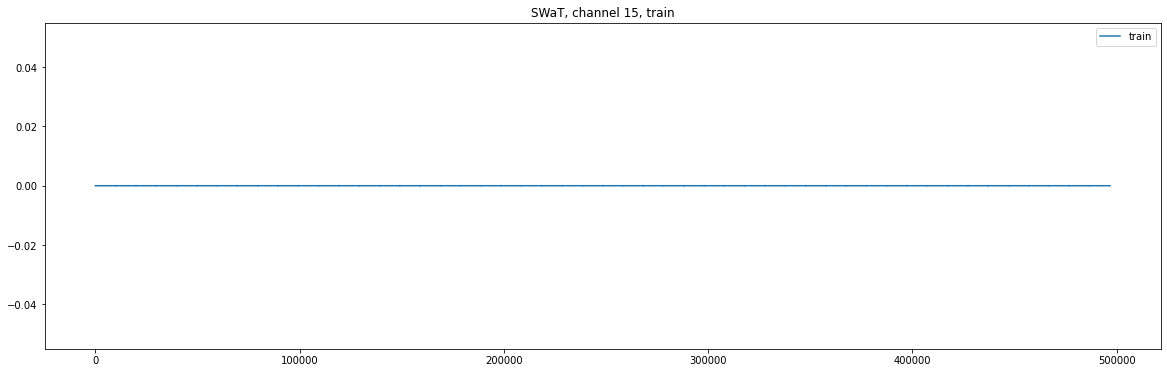

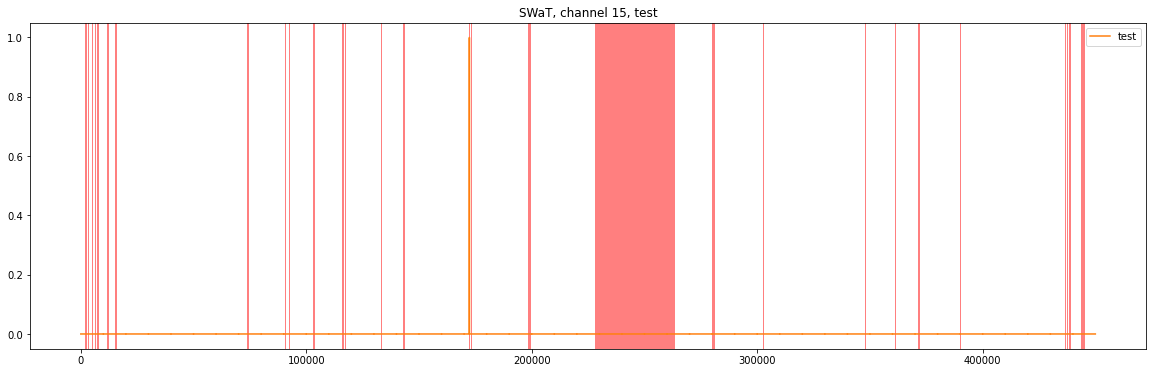

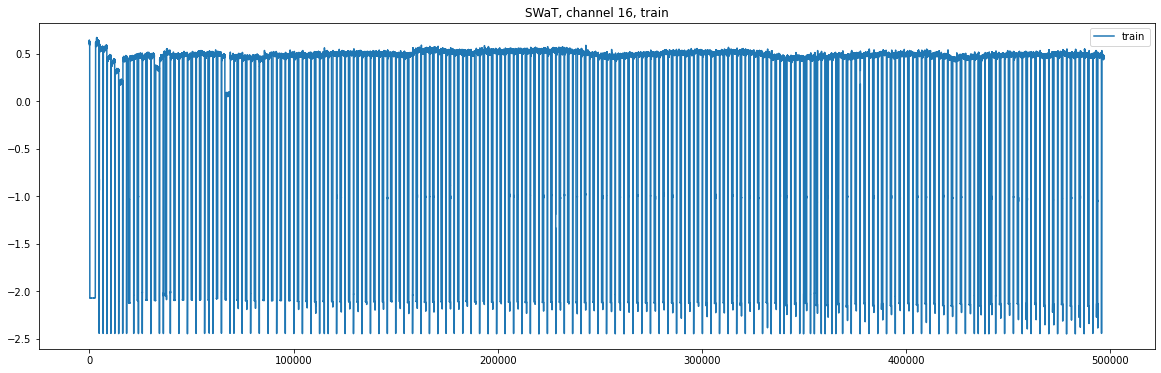

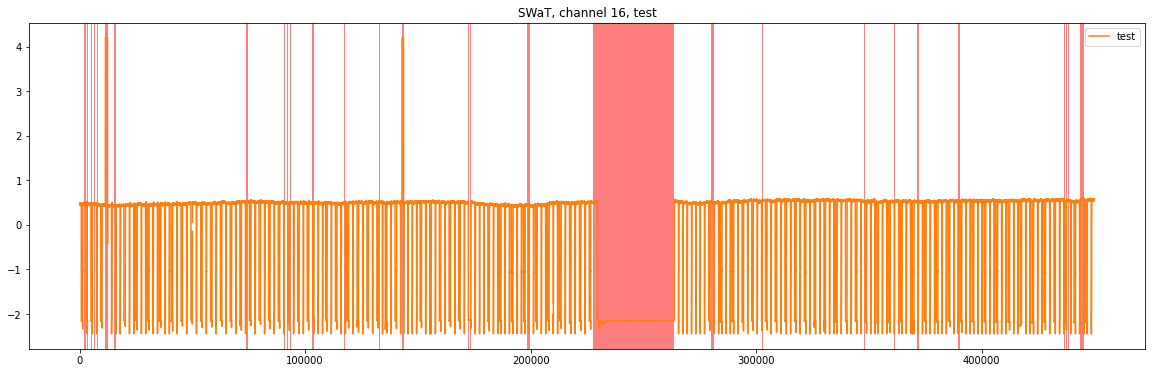

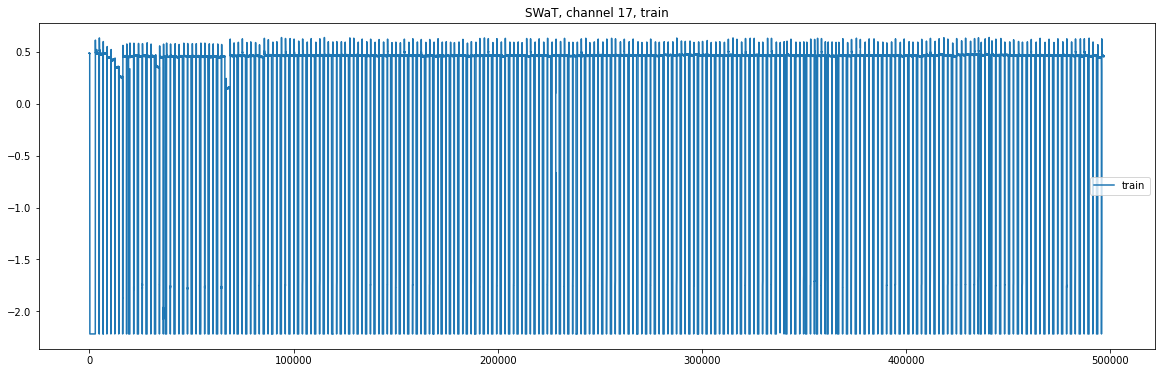

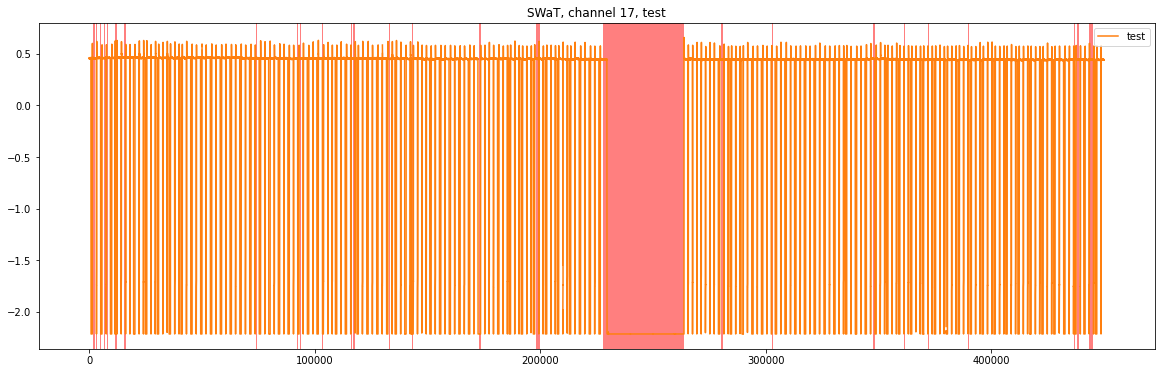

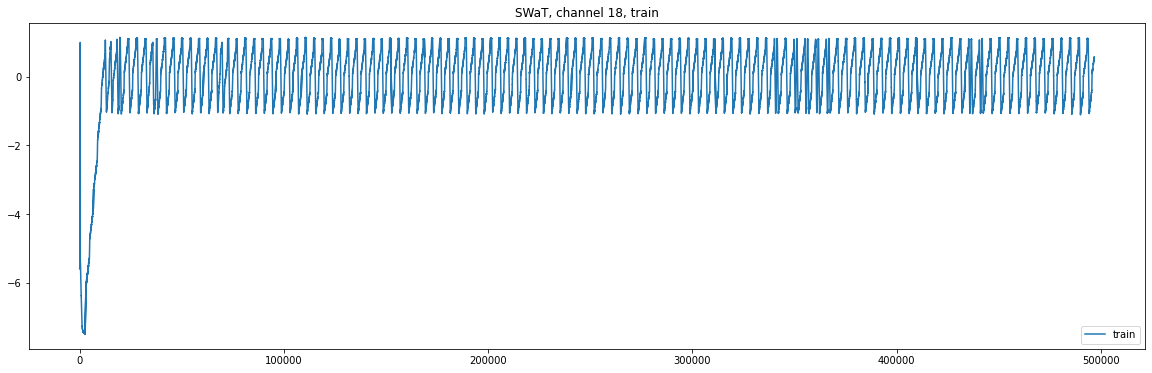

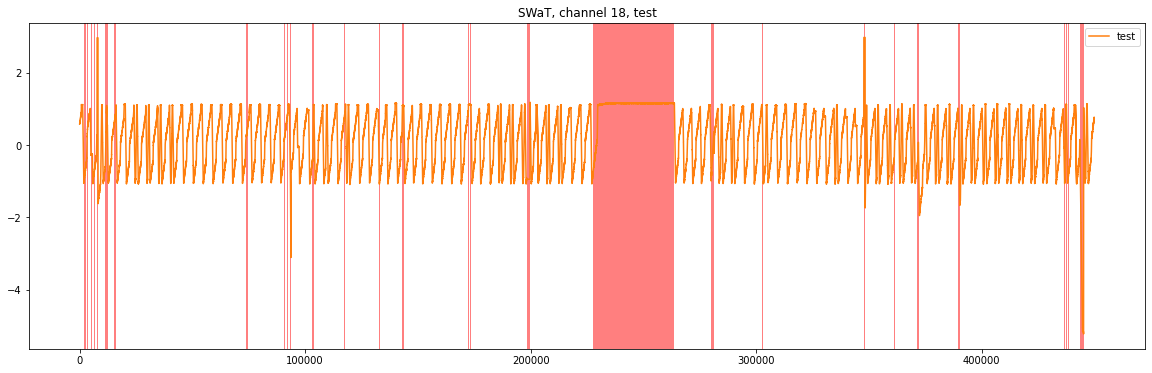

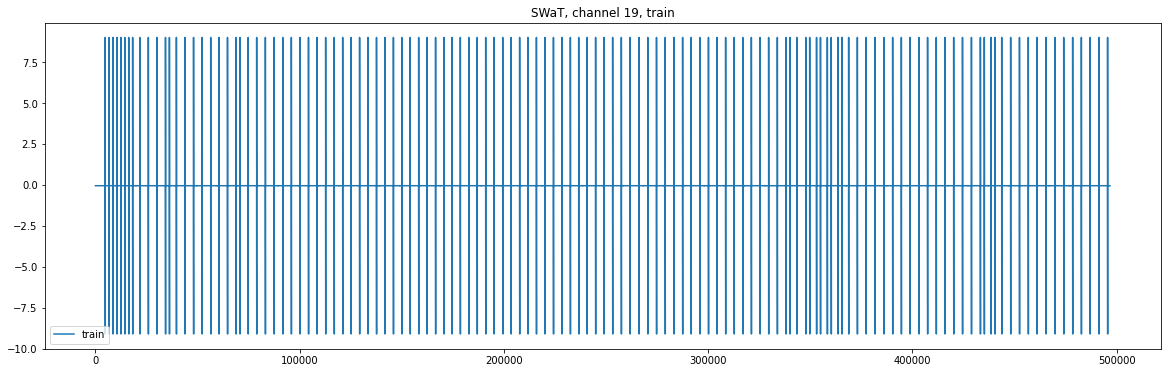

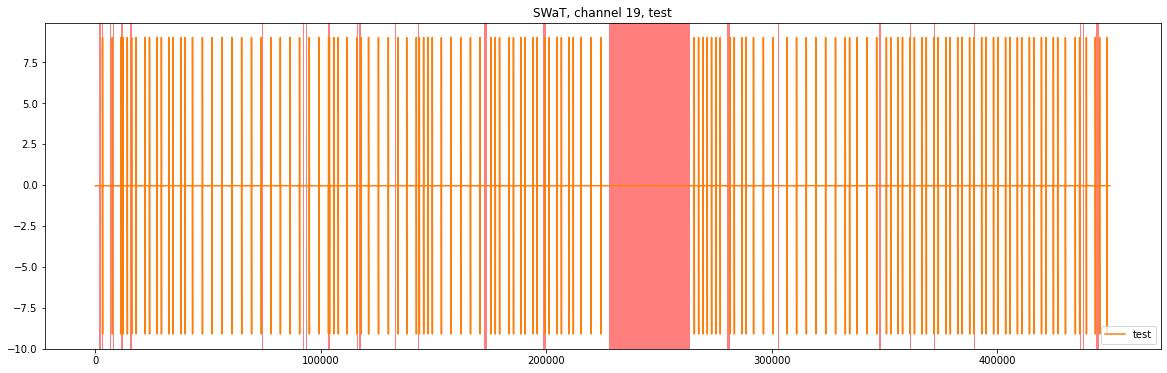

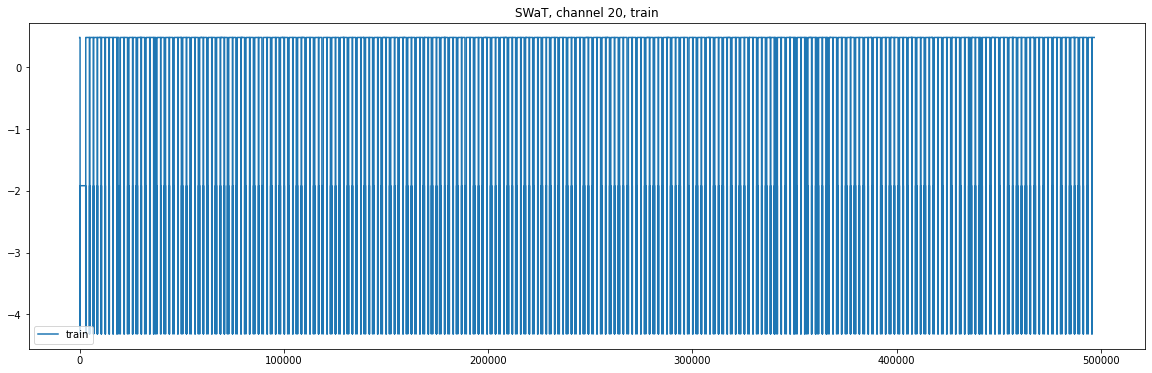

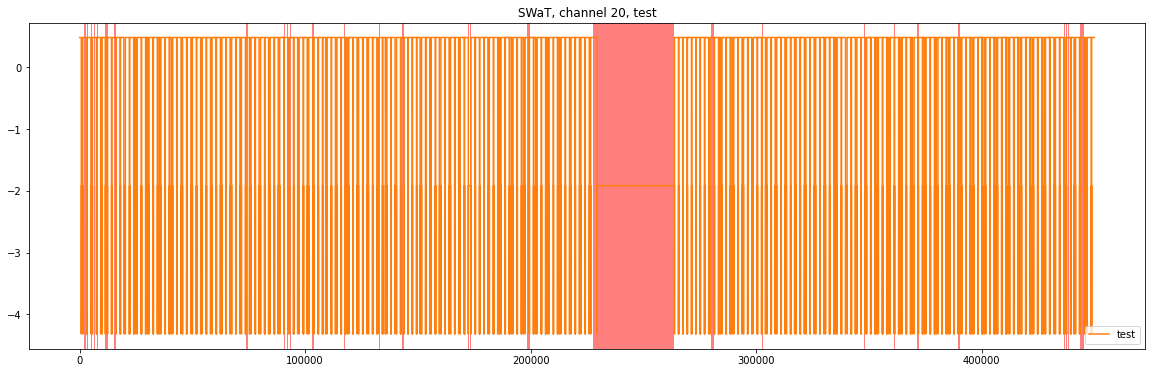

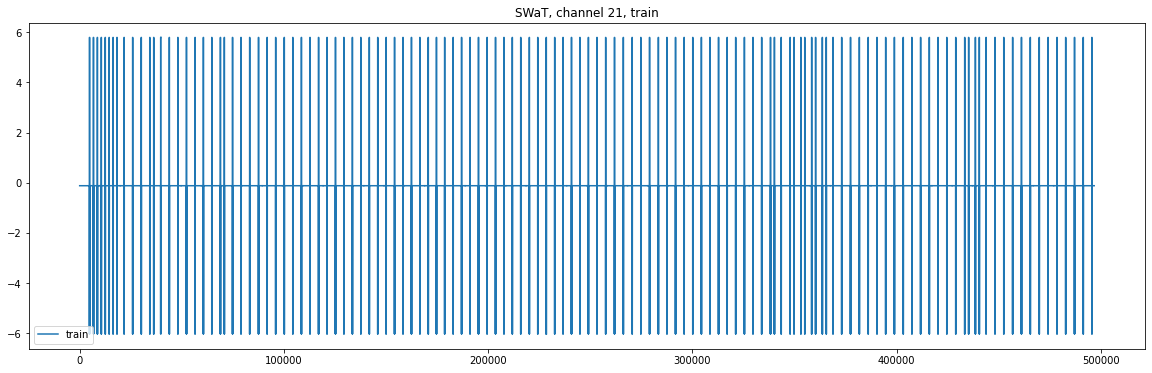

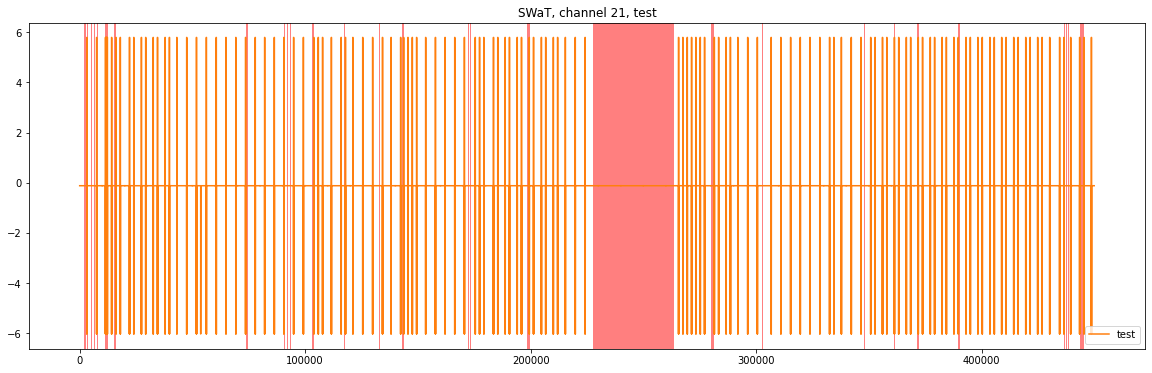

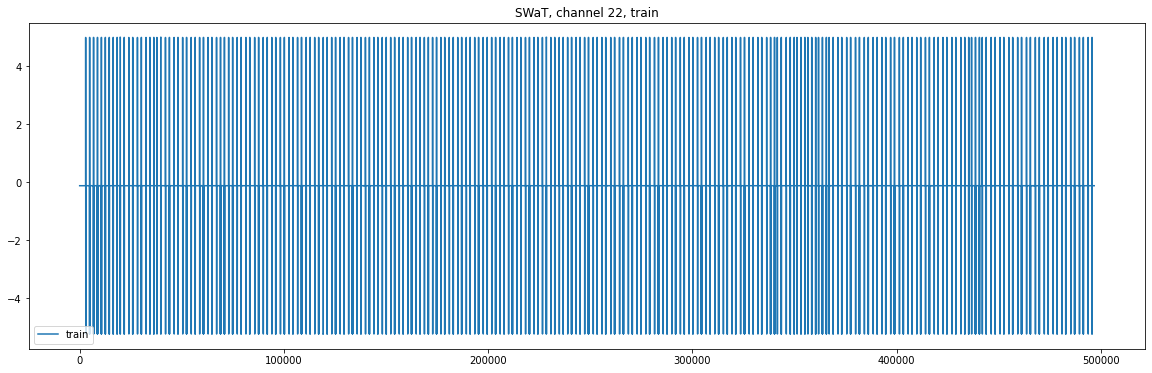

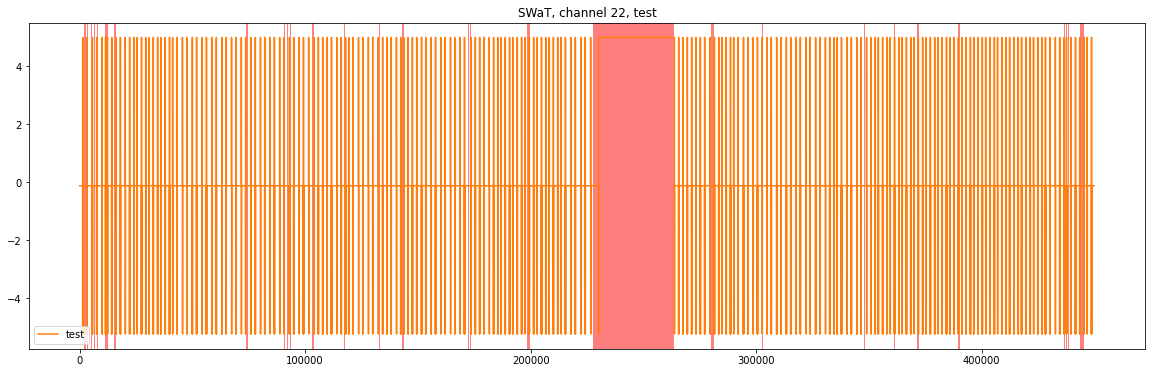

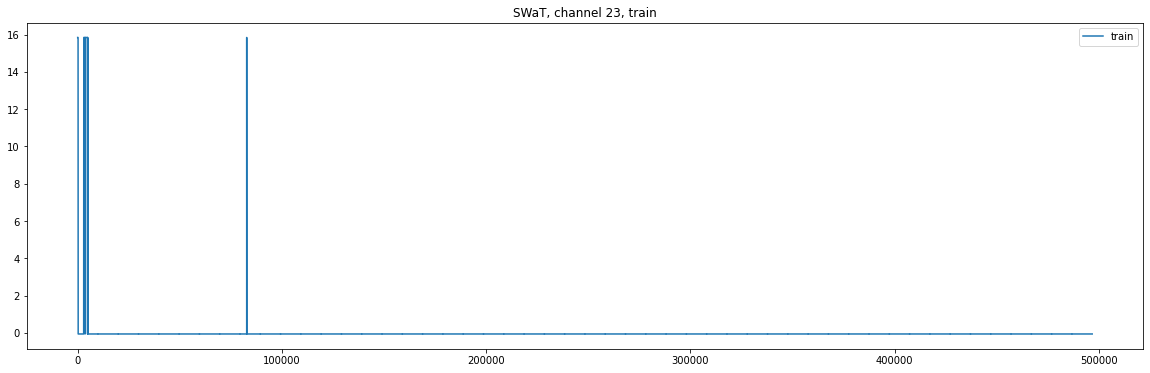

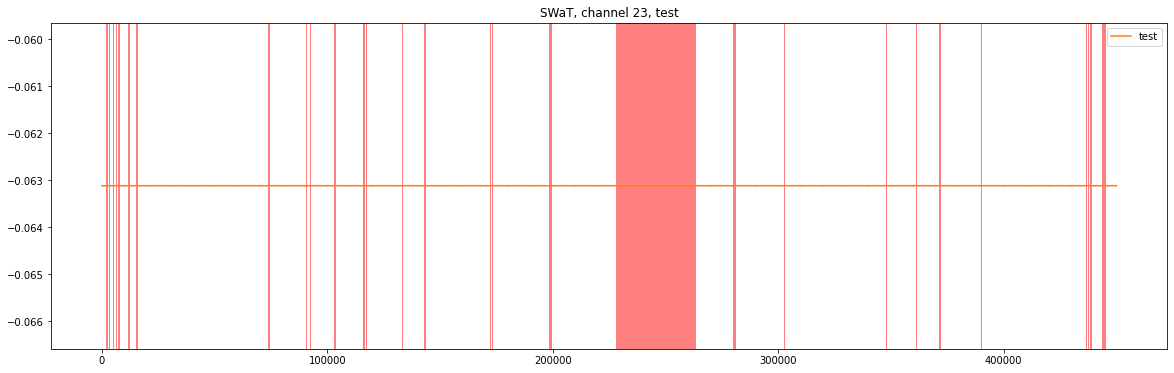

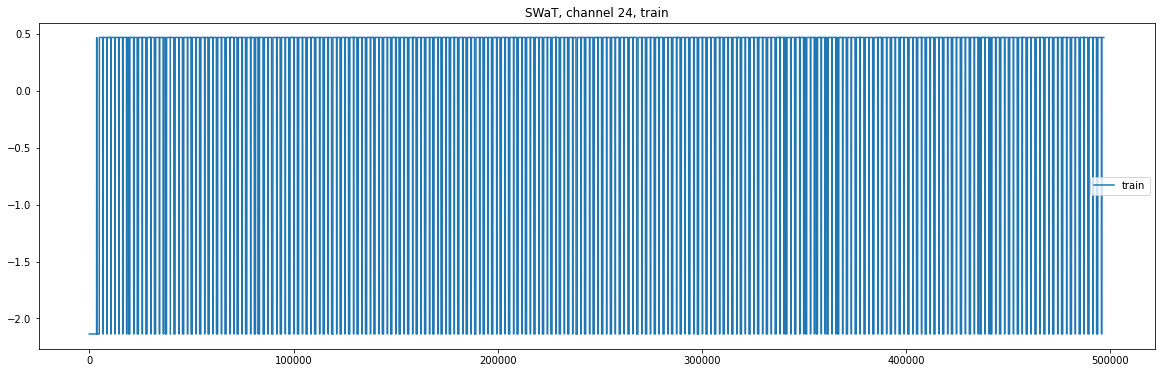

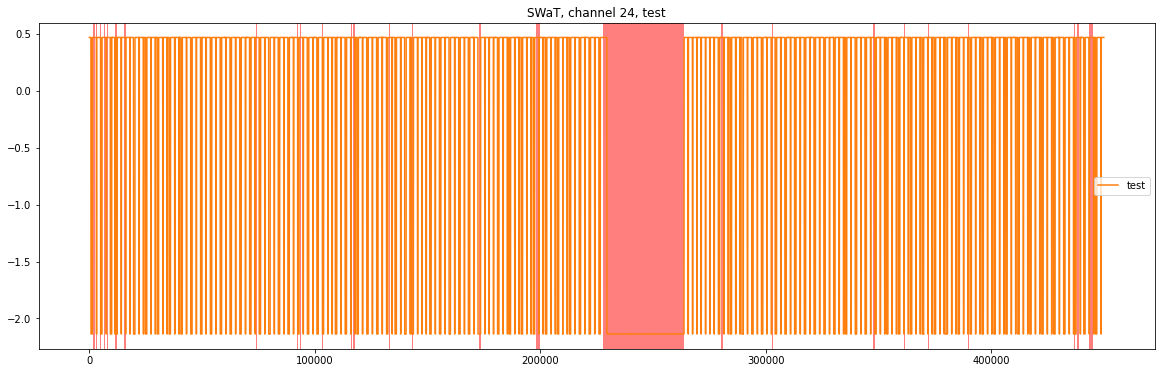

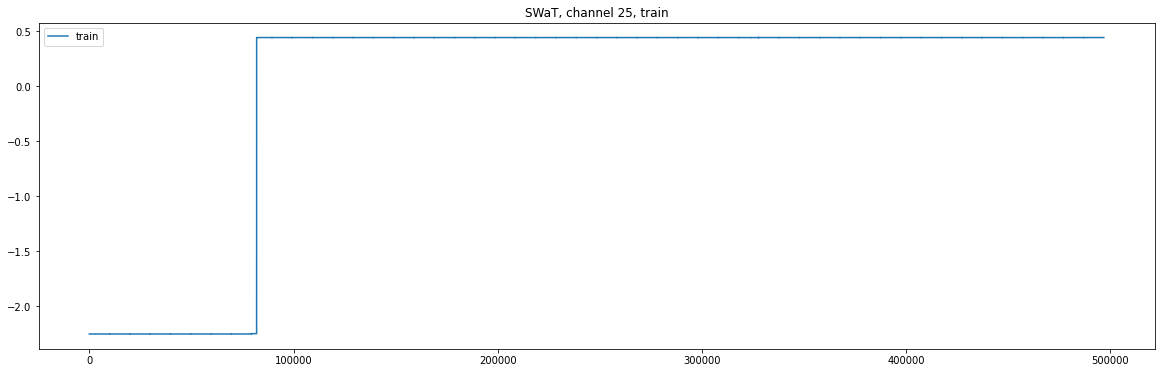

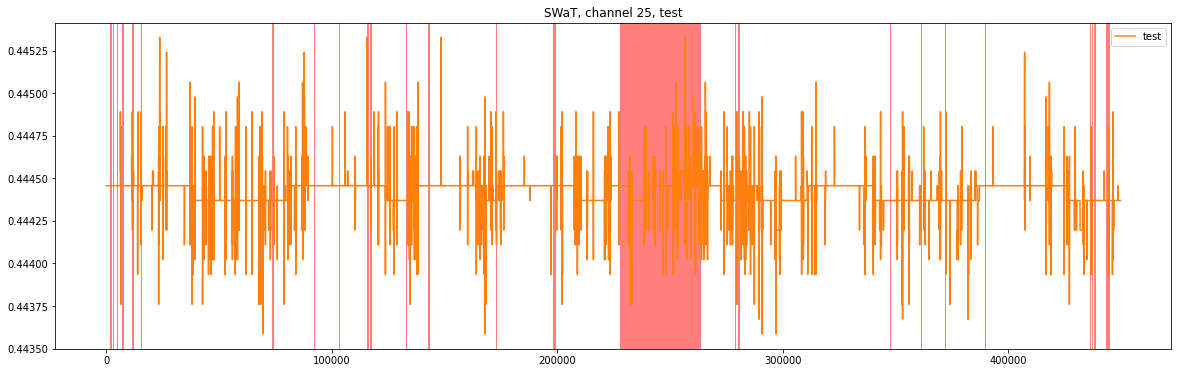

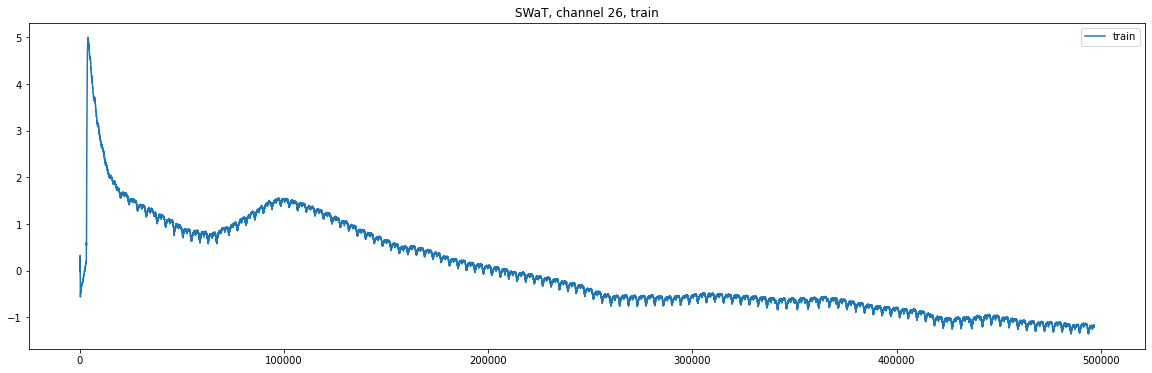

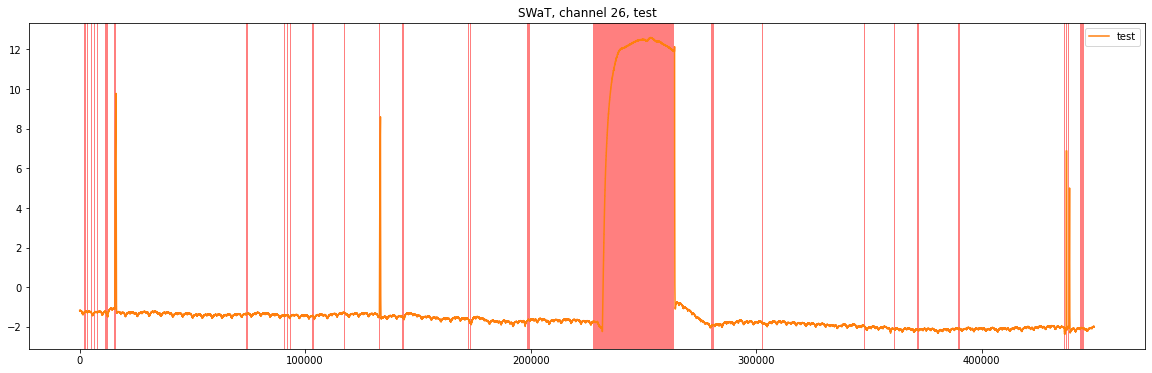

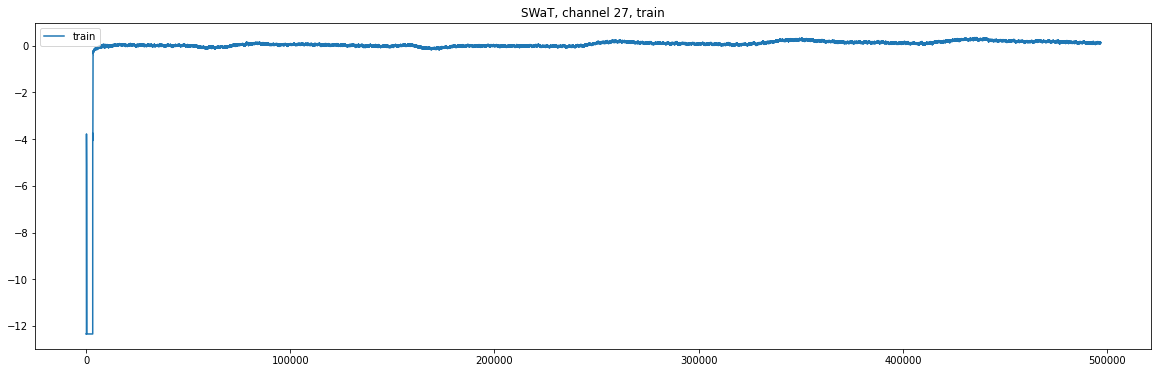

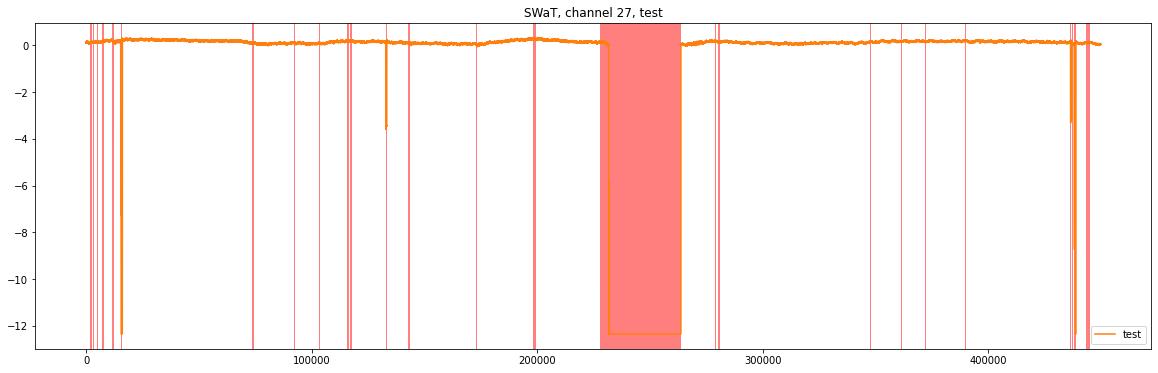

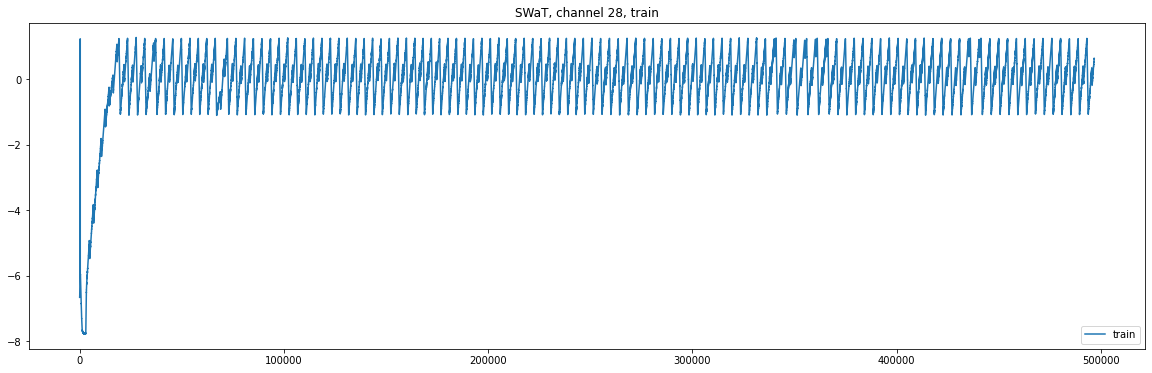

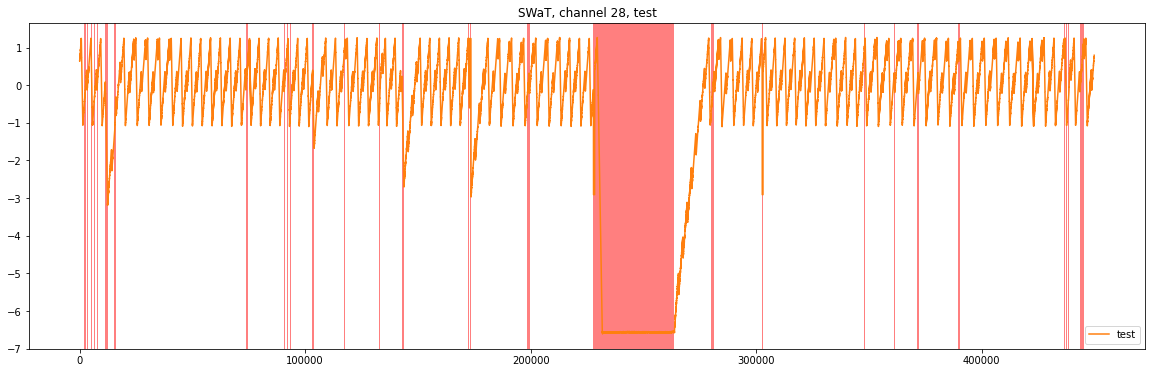

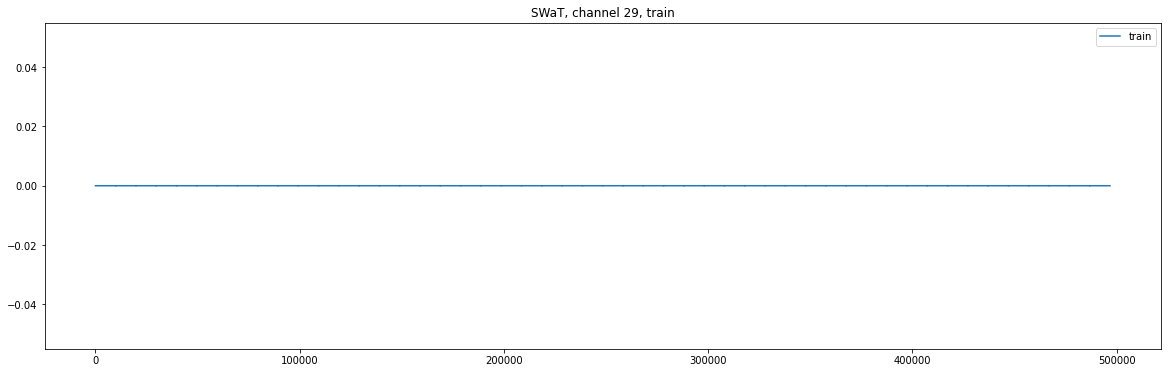

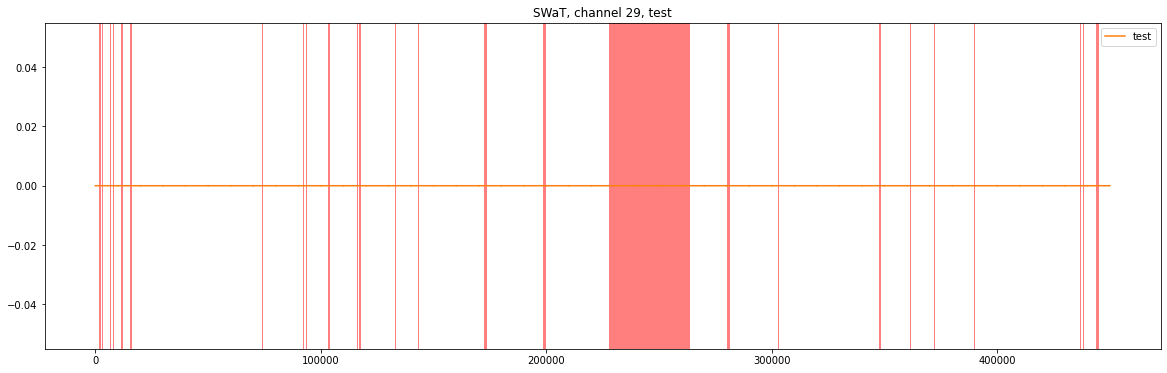

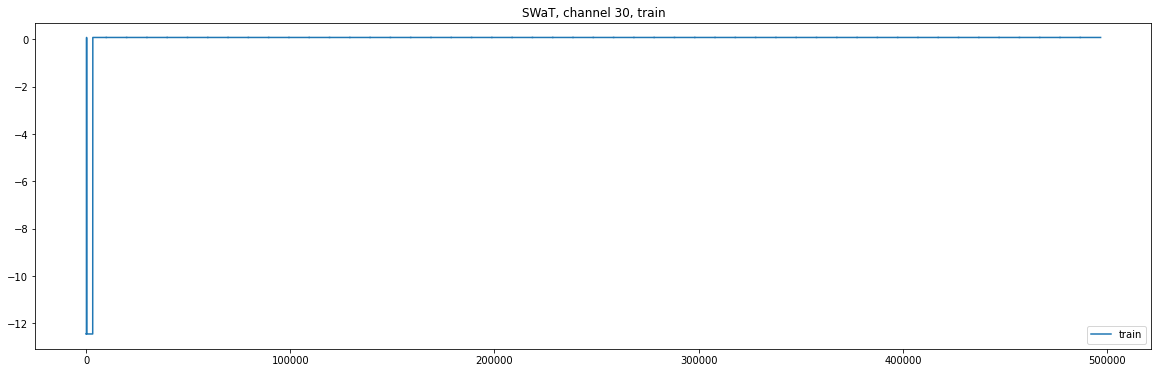

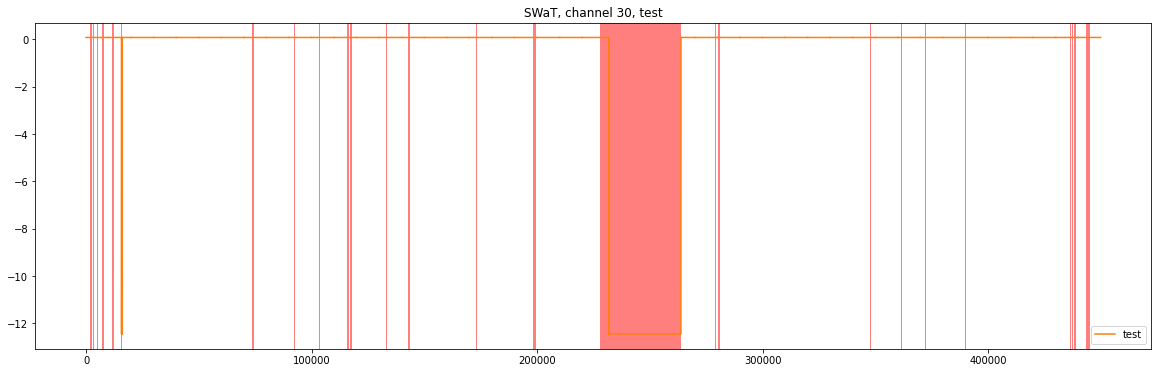

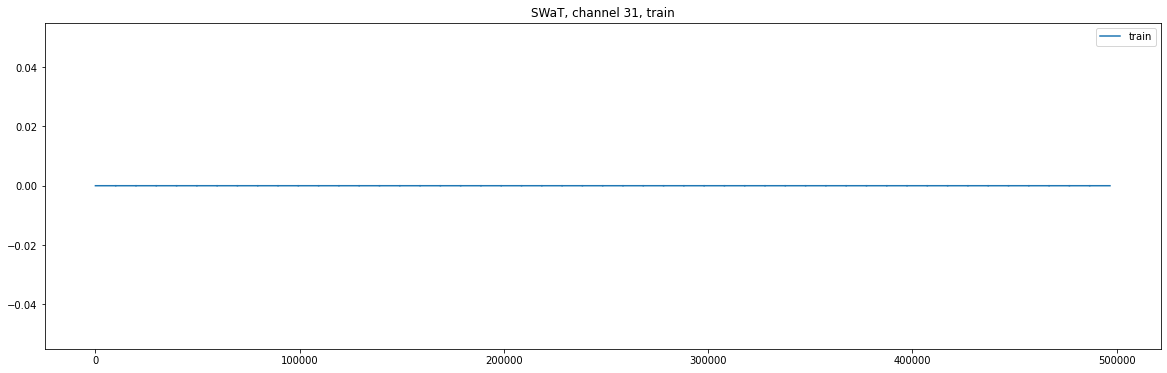

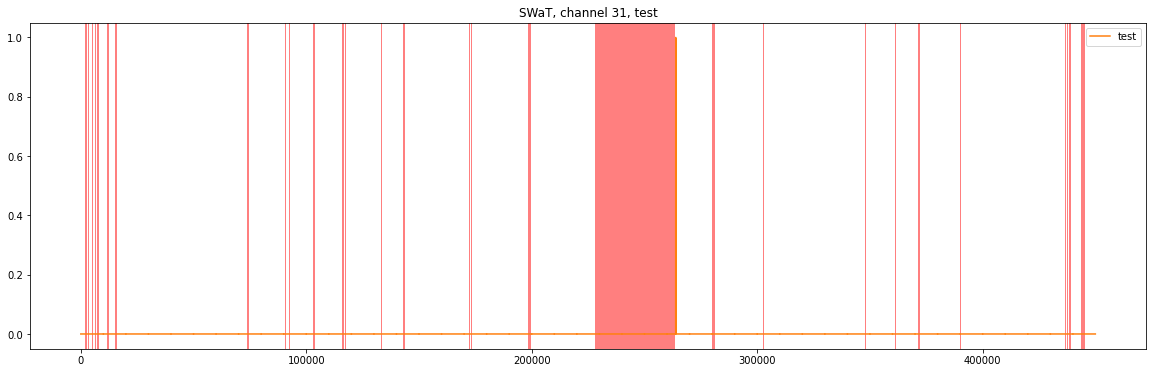

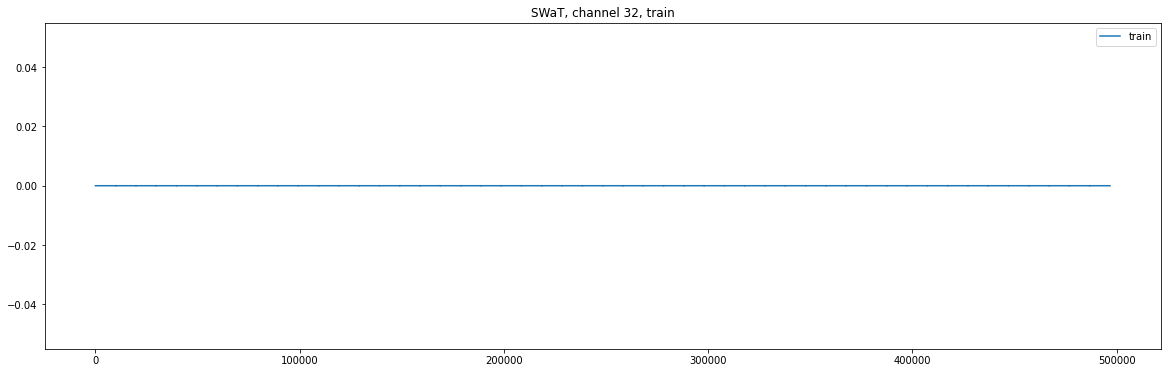

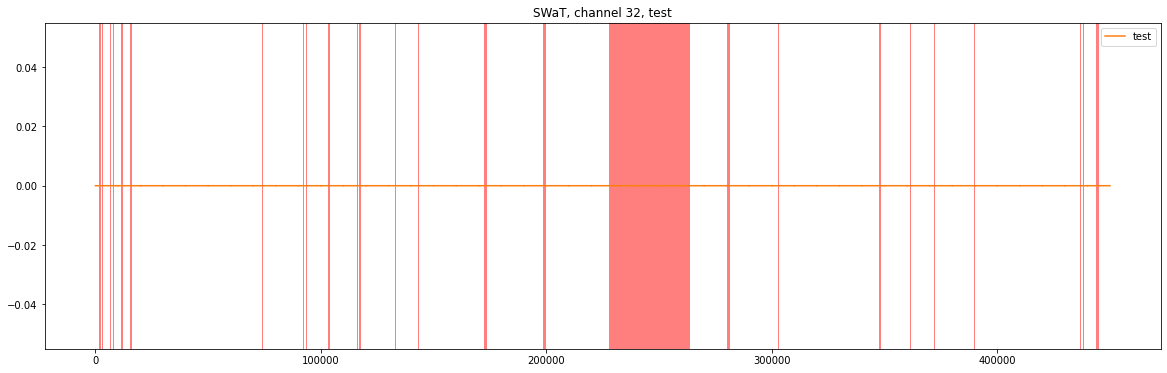

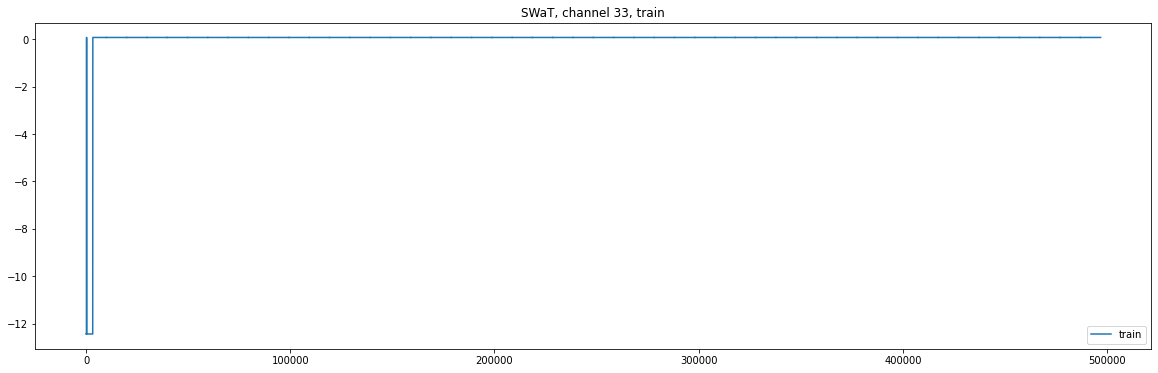

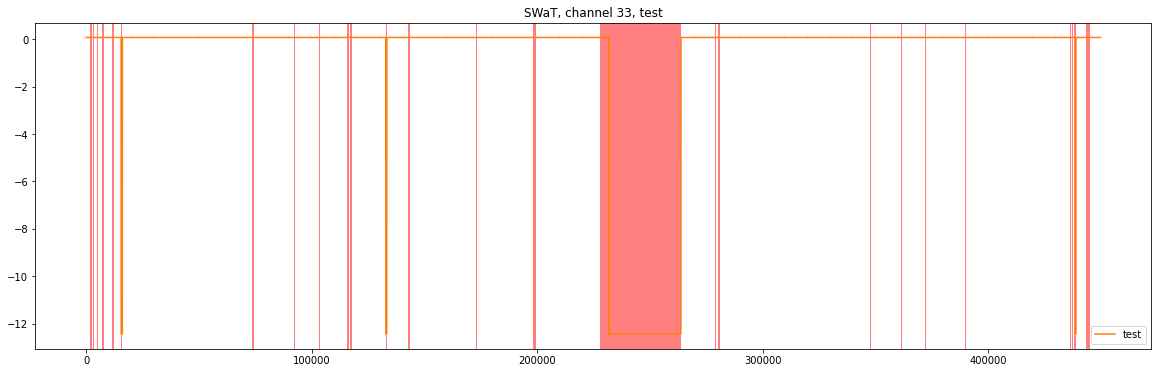

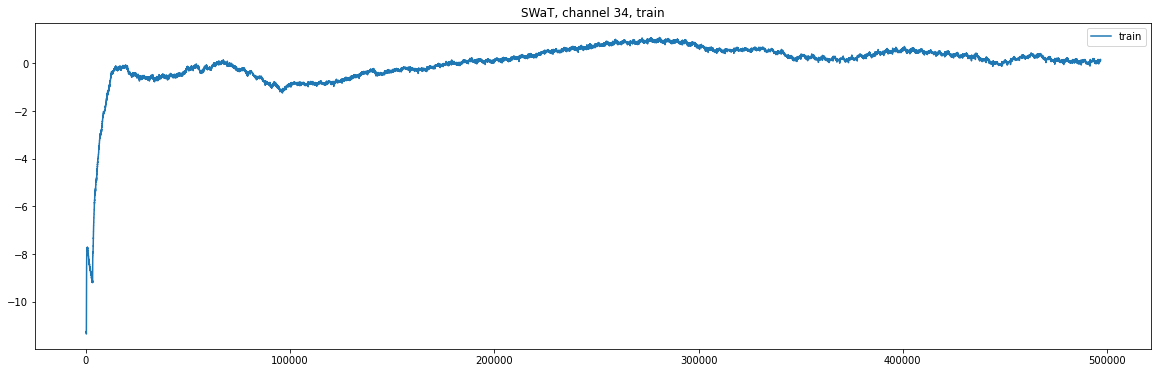

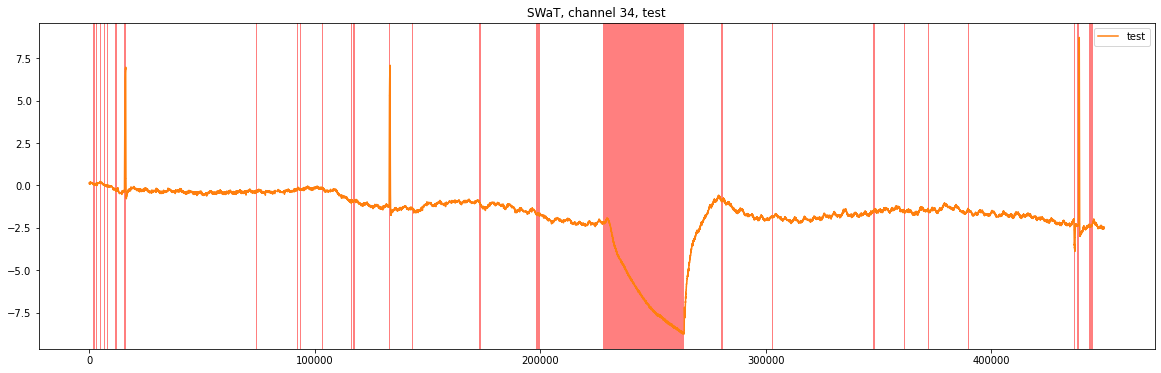

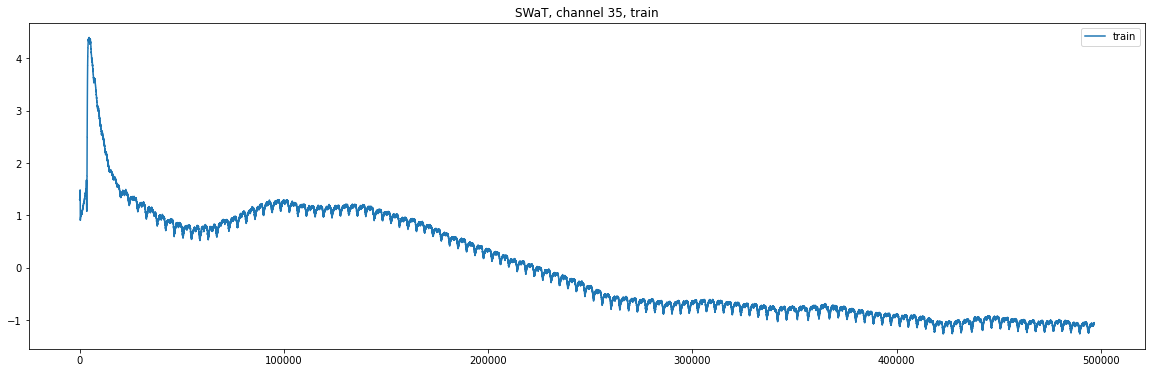

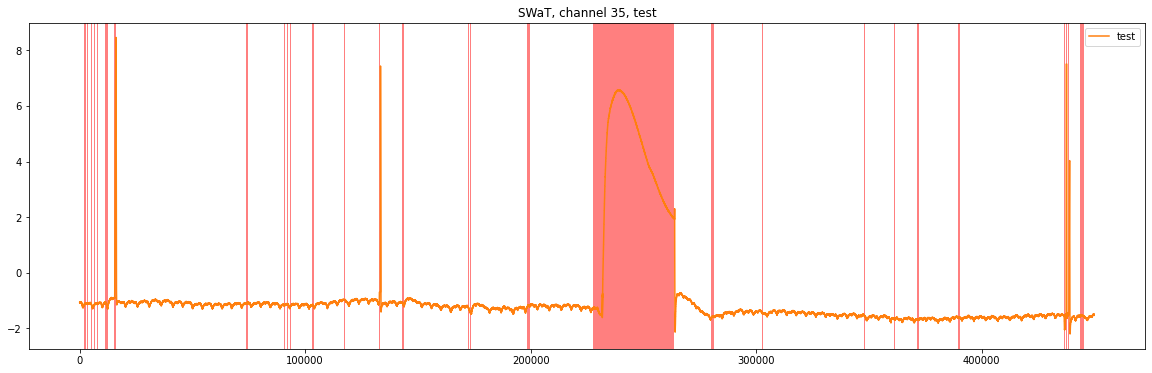

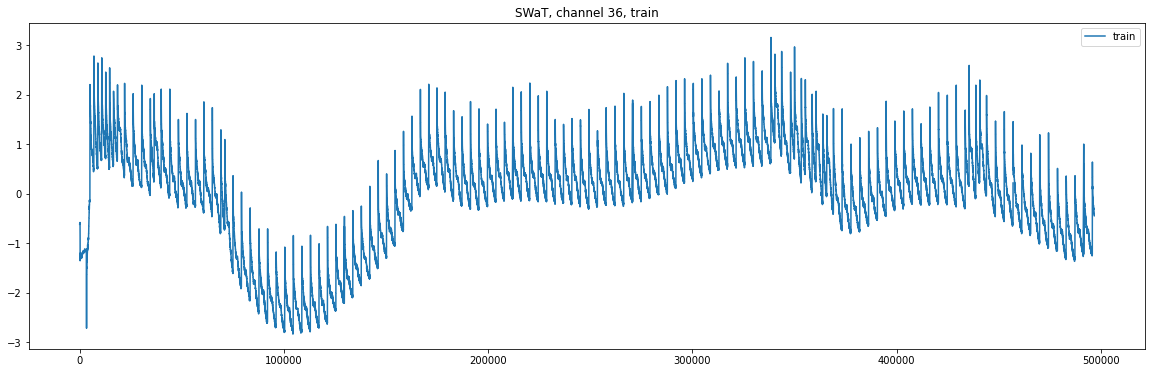

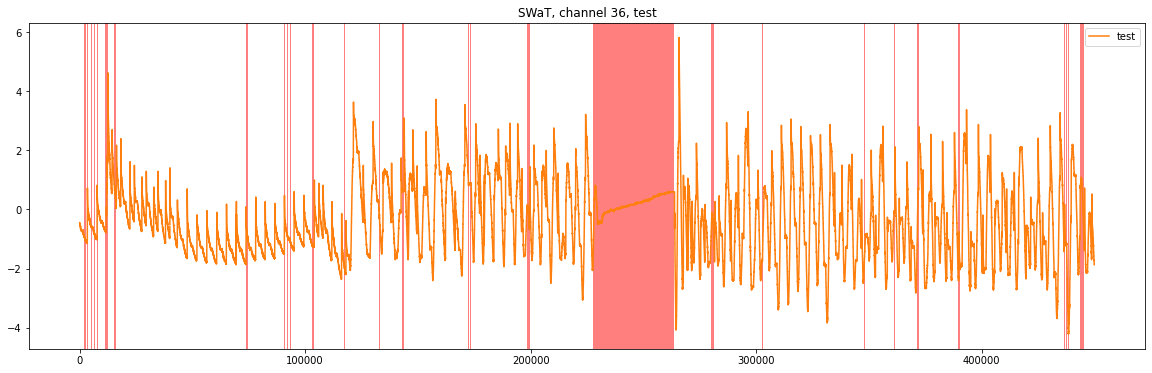

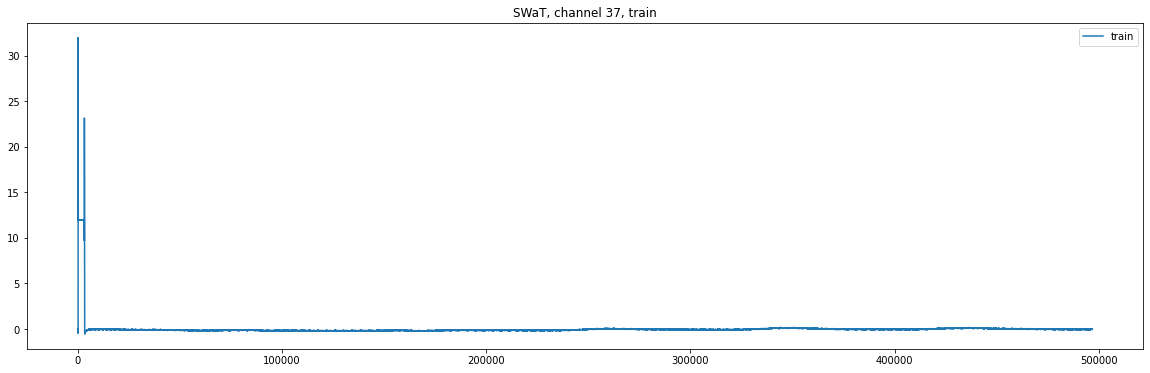

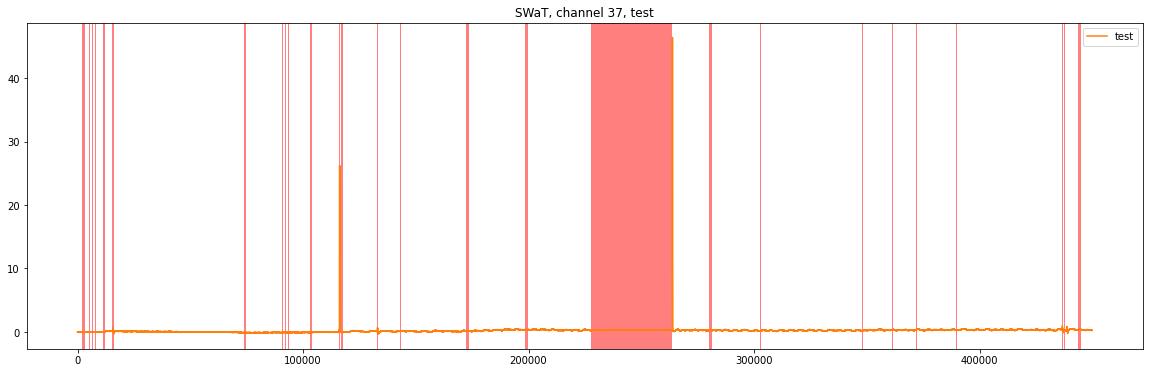

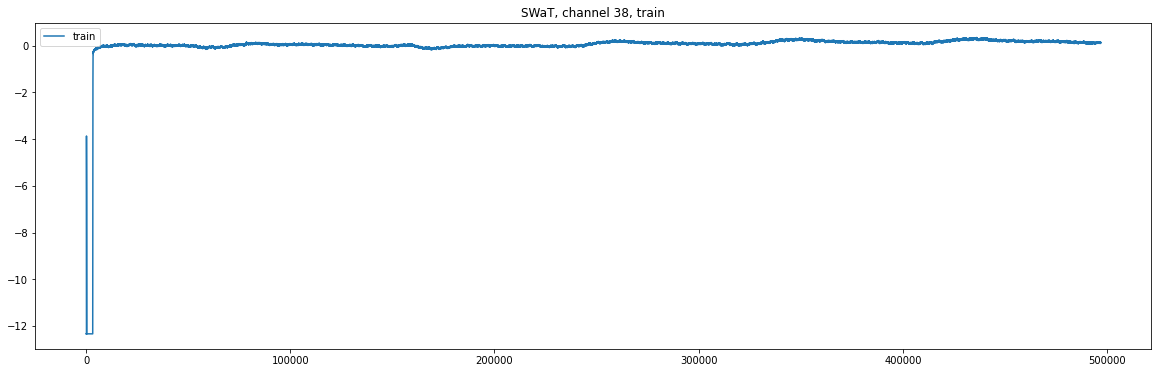

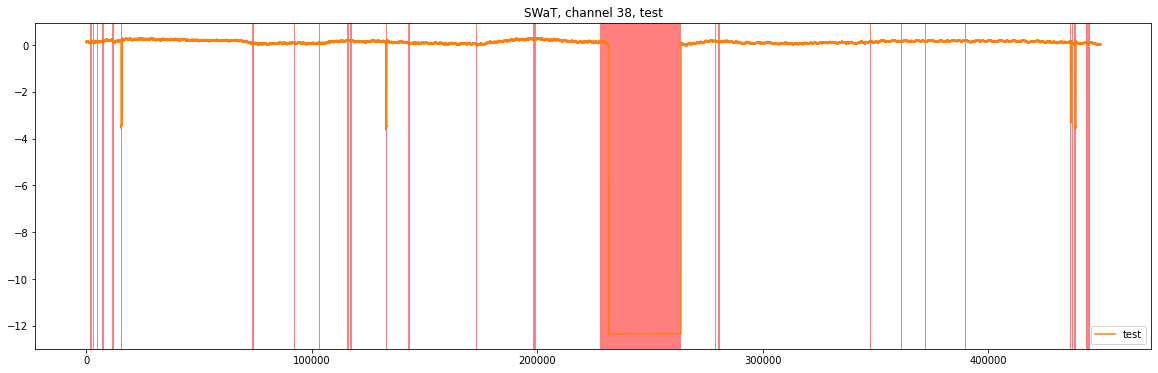

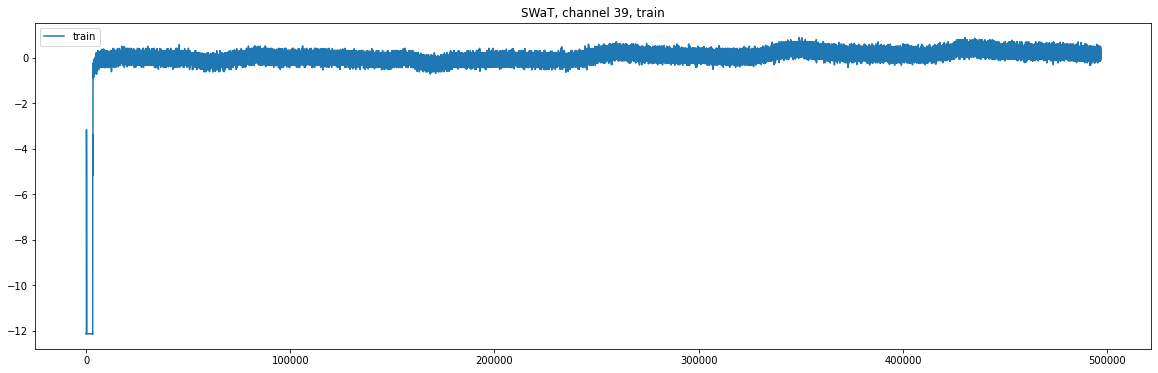

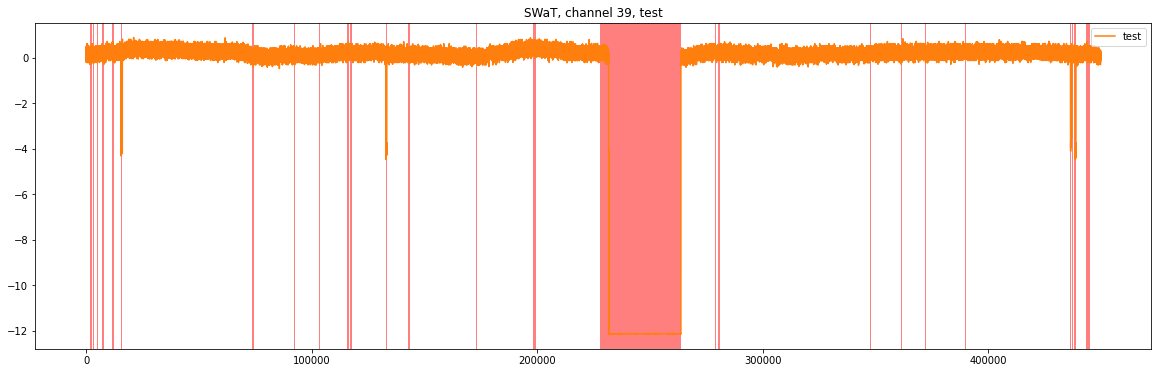

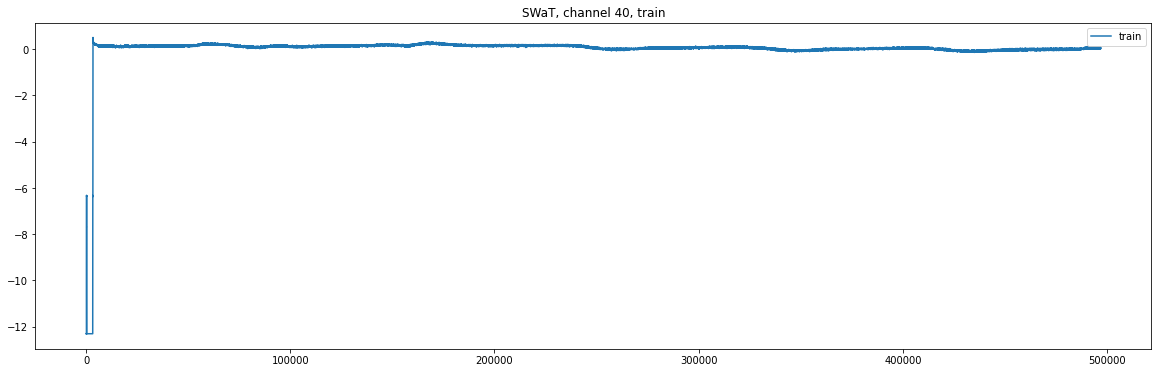

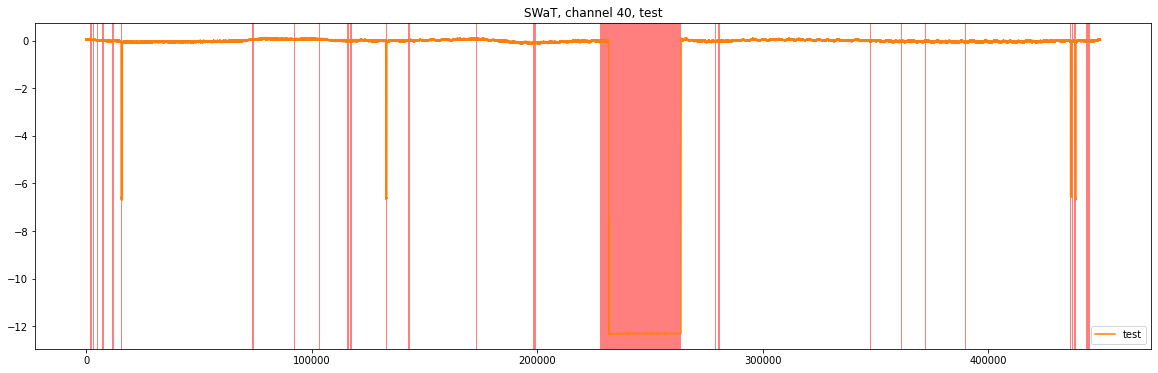

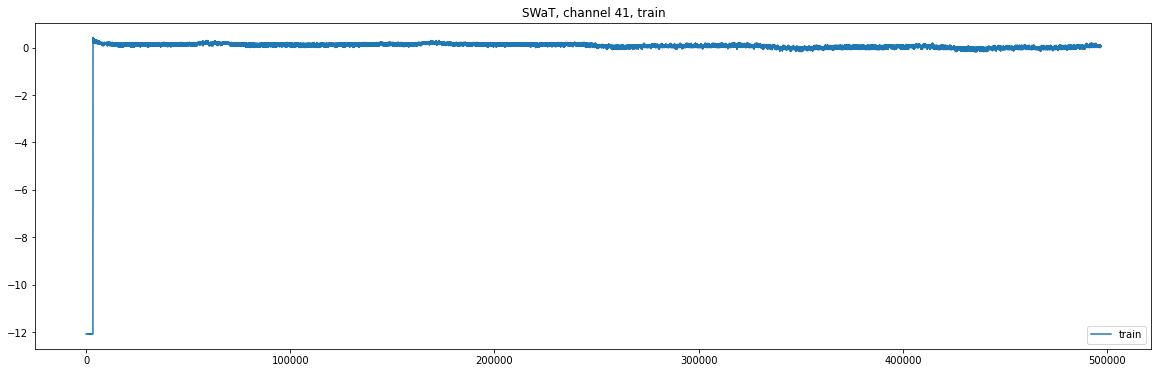

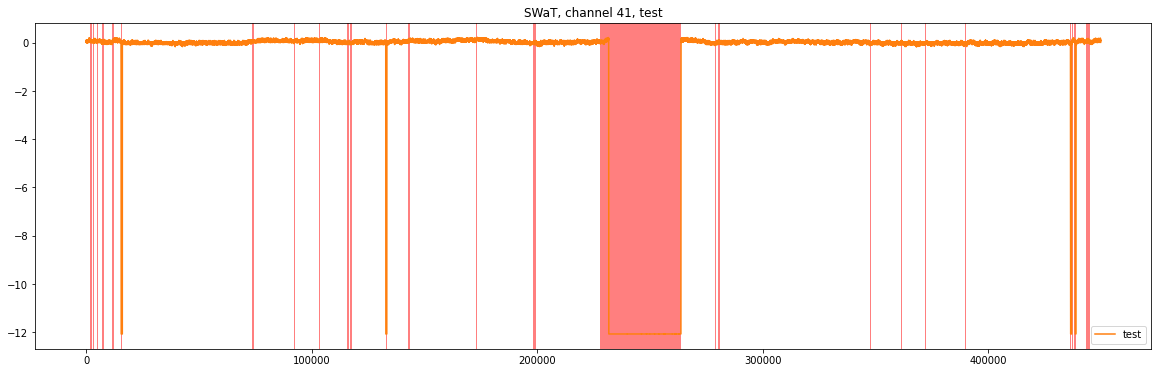

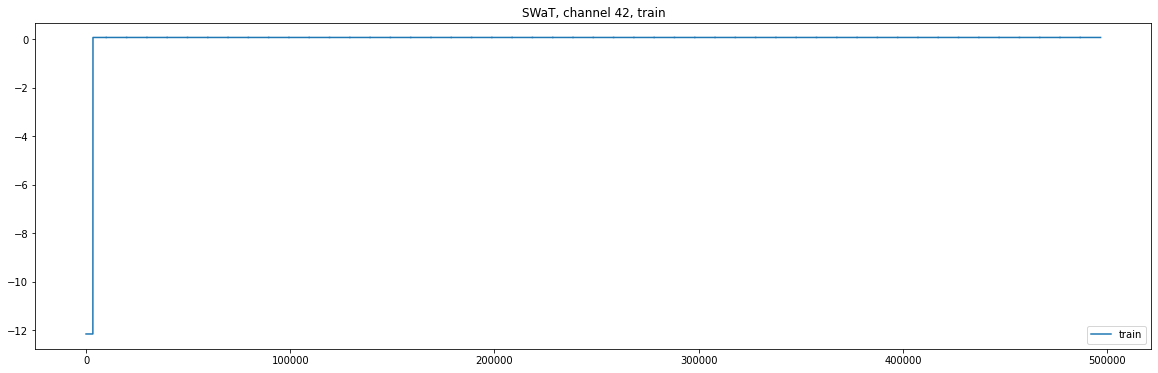

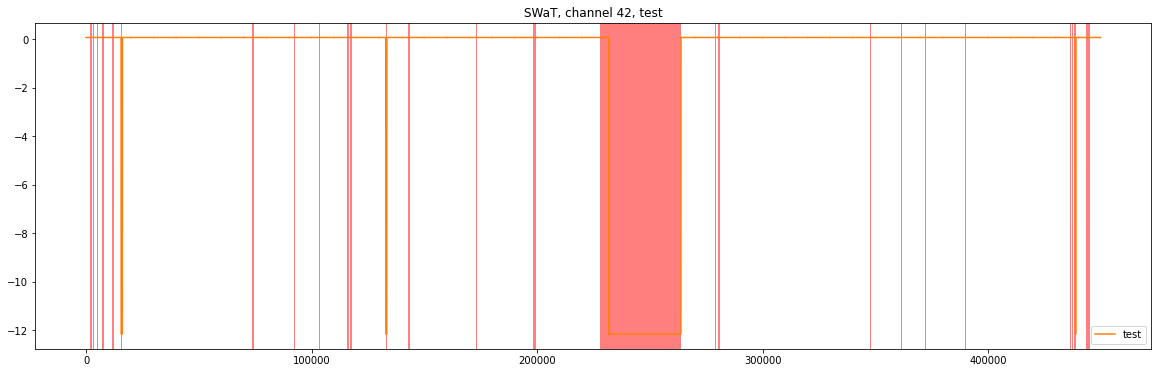

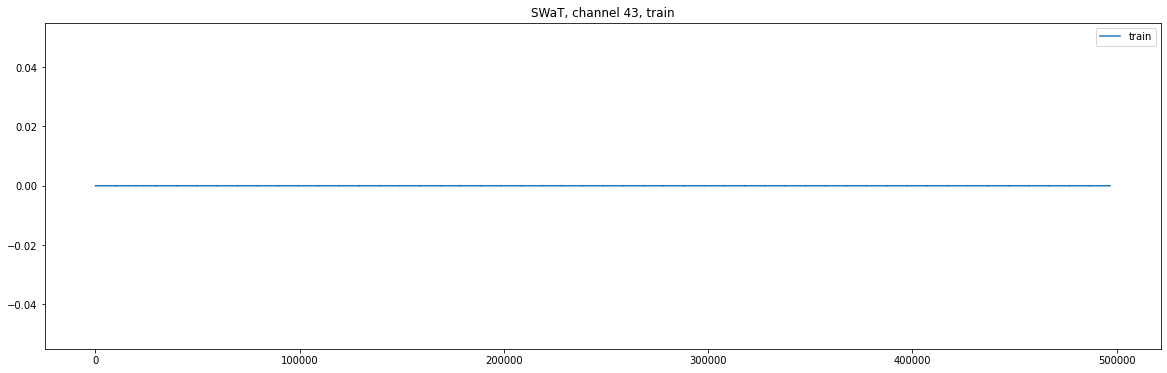

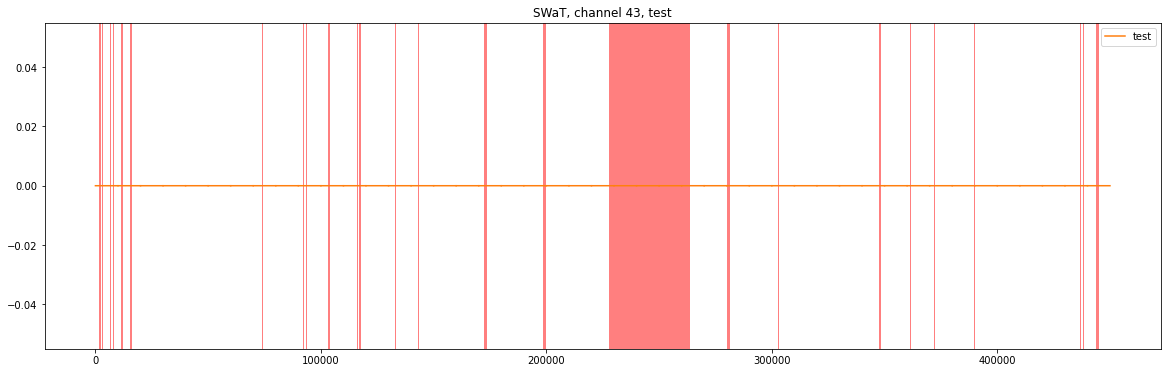

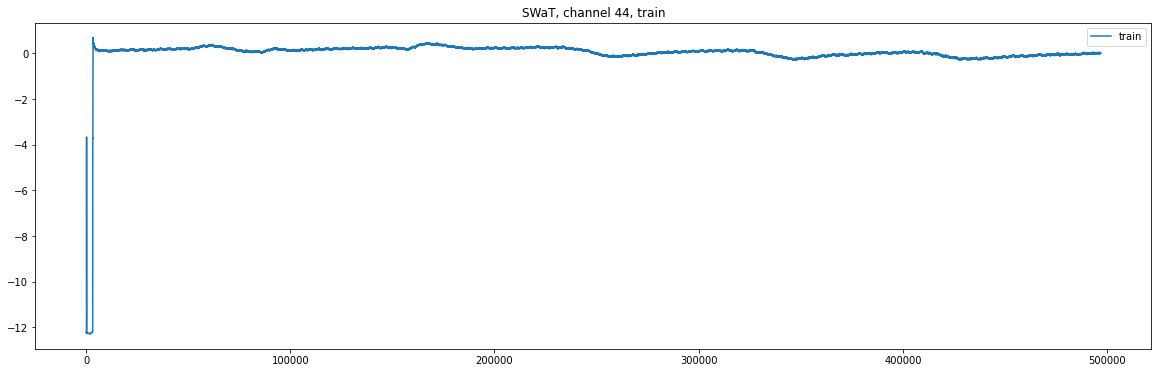

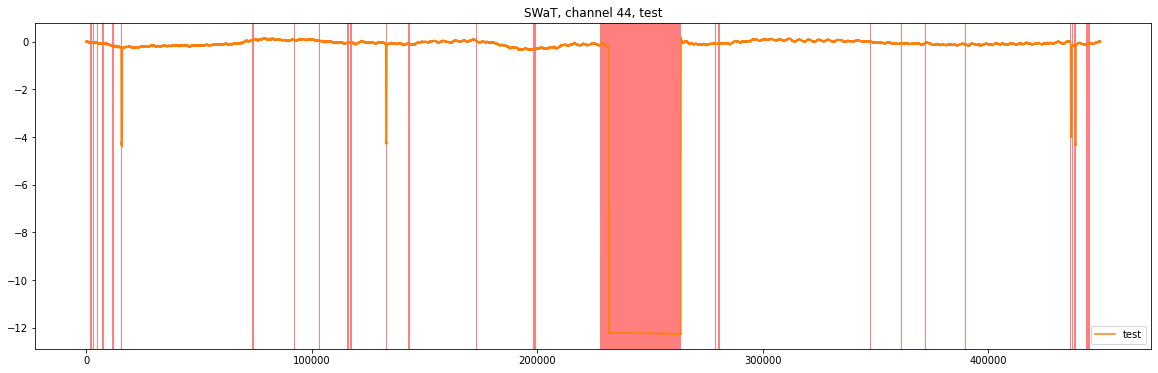

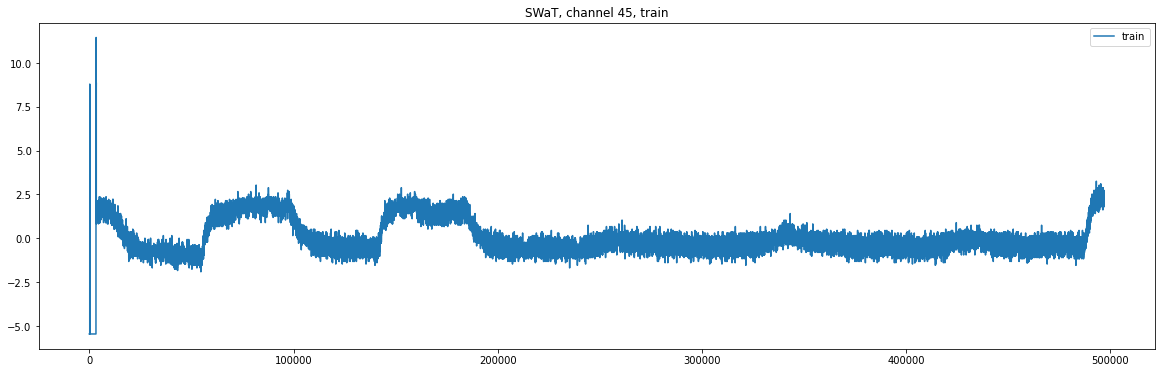

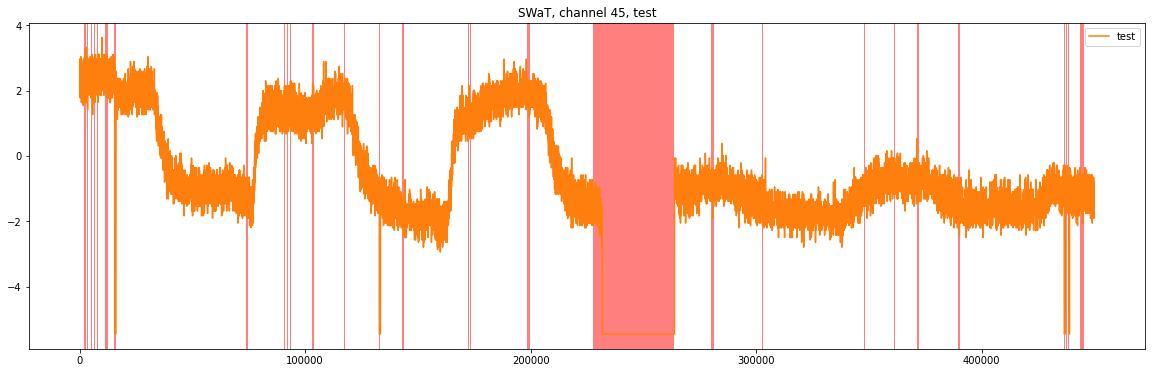

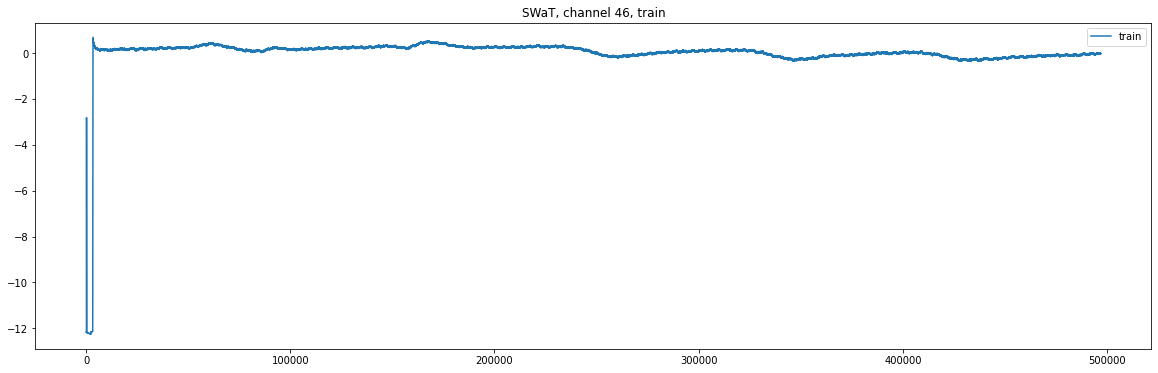

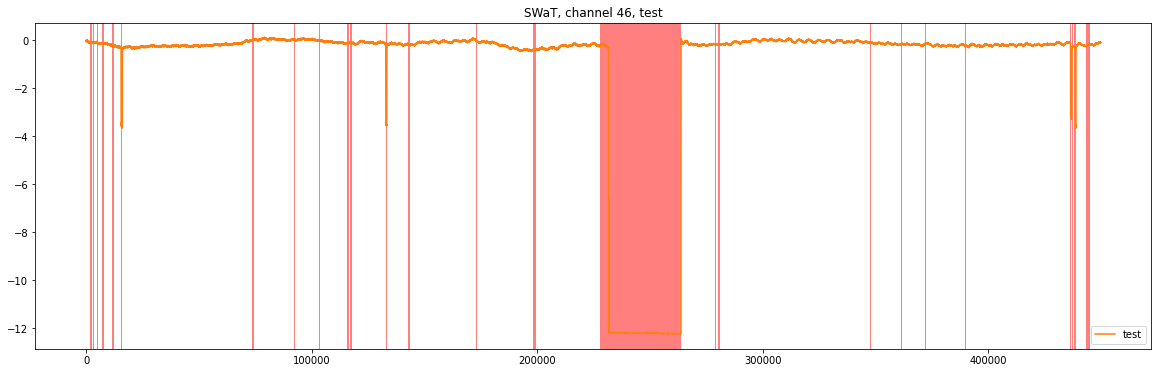

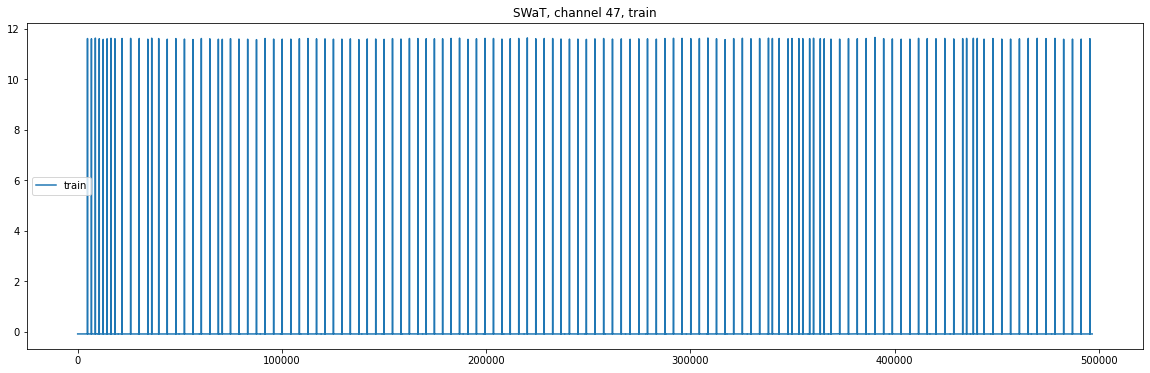

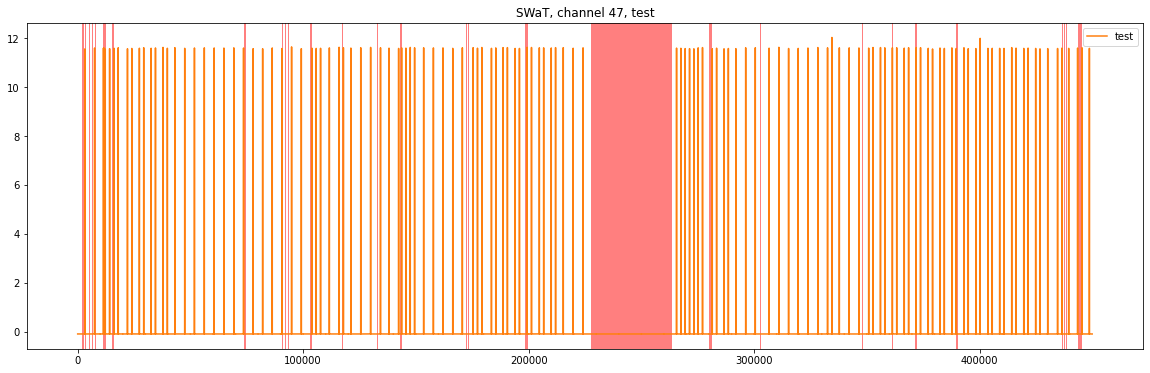

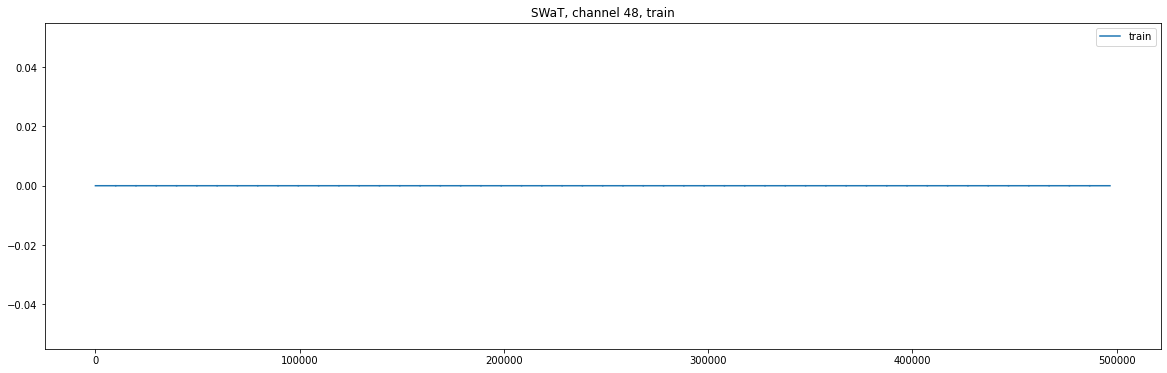

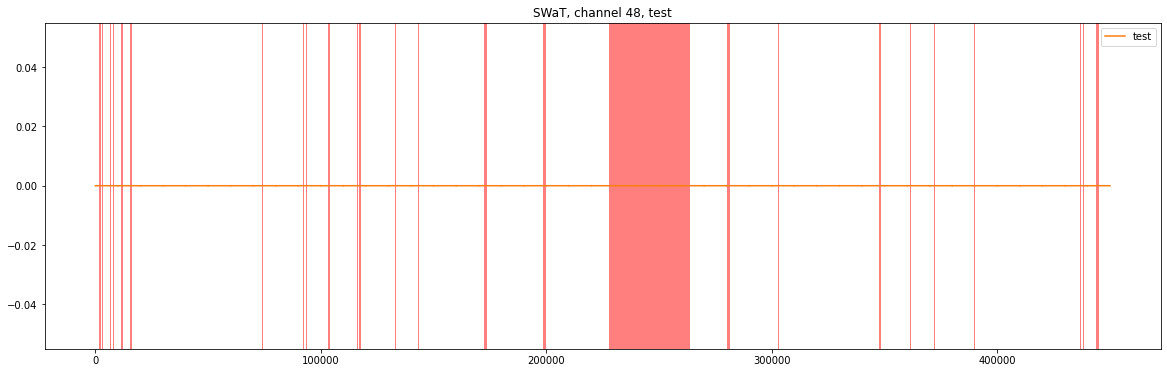

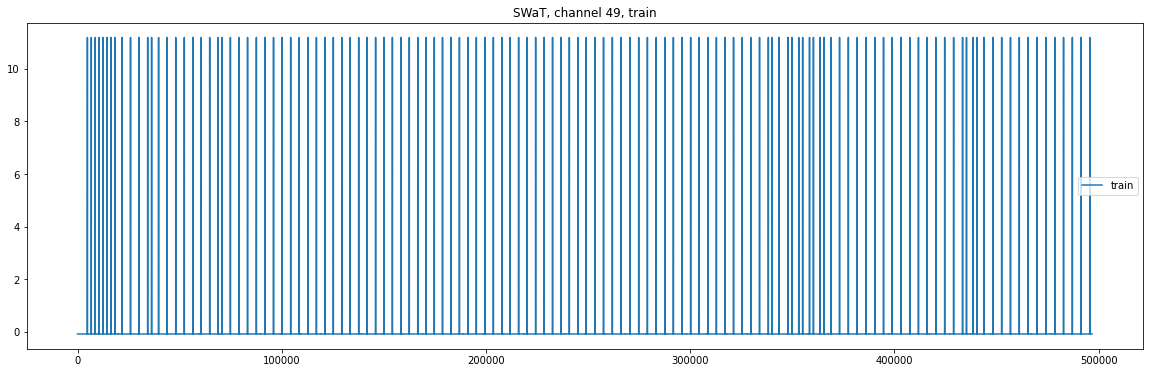

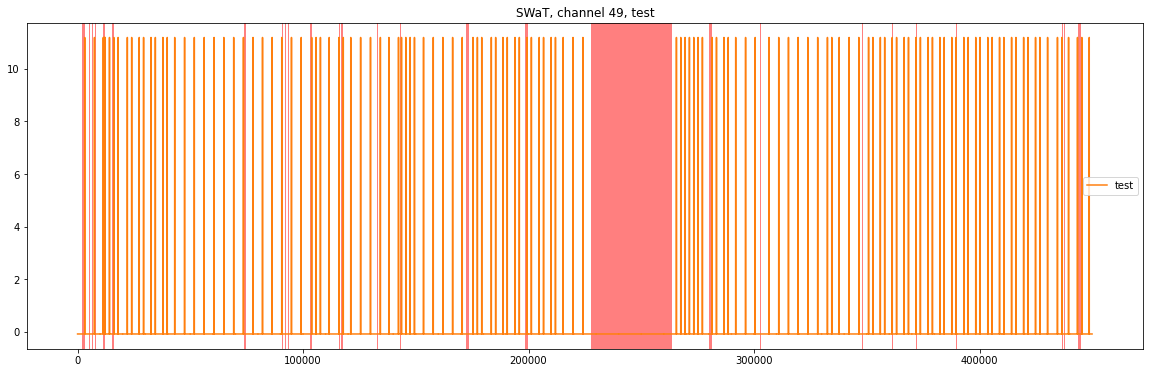

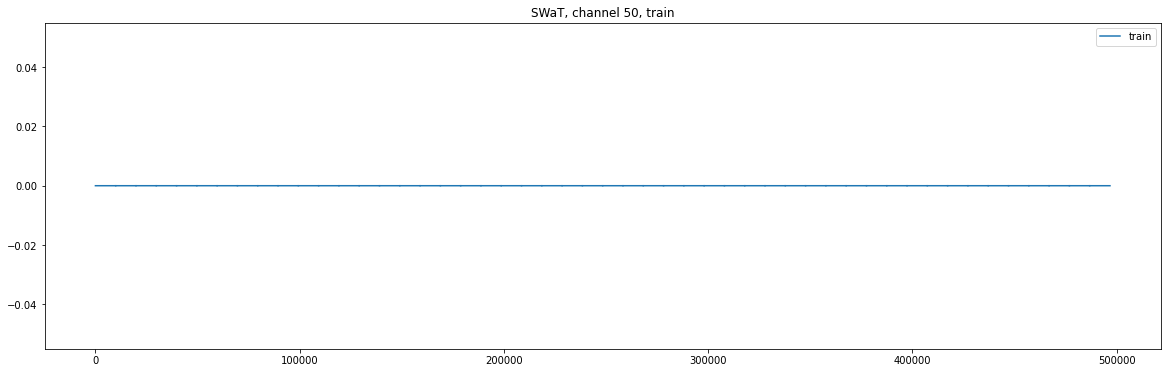

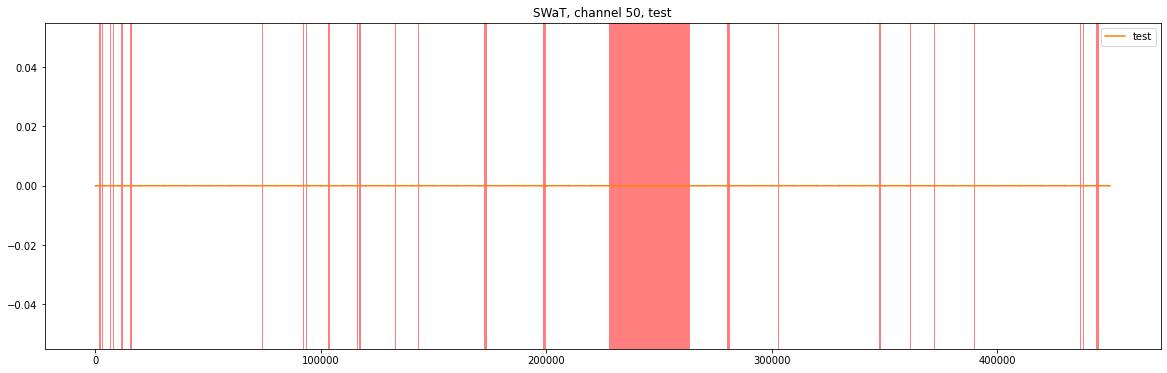

In [18]:
C = 7
for c in range(args.num_channels):
    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, train")
    plt.plot(train_X[:, c], label="train", color="#1f77b4")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.title(f"{args.dataset}, channel {c}, test")
    plt.plot(test_X[:, c], label="test", color="#ff7f0e")
    plot_anomaly(plt, test_y)
    plt.legend()
    plt.show()